In [1]:
import numpy as np
import pandas as pd
import datetime
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
DATA_LOC = "../data/data_a.csv"

In [3]:
raw_data = pd.read_csv(DATA_LOC)
raw_data.head()
# How many dataset? Shape of dataset

time  temperature_2m_c  relative_humidity_2m_percent  \
0  2020-01-01T00:00              23.2                            95   
1  2020-01-01T01:00              23.6                            95   
2  2020-01-01T02:00              24.4                            93   
3  2020-01-01T03:00              24.7                            88   
4  2020-01-01T04:00              25.1                            88   

   dew_point_2m_c  rain_mm  snowfall_cm  cloud_cover_percent  \
0            22.4      0.9          0.0                  100   
1            22.7      1.7          0.0                   97   
2            23.3      0.2          0.0                   92   
3            22.5      0.4          0.0                   53   
4            22.9      0.9          0.0                  100   

   wind_speed_10m_kph  wind_direction_10m_degrees  wind_gusts_10m_kph  
0                19.6                          36                44.3  
1                21.4                          41                44.6  
2                21.0                          35                45.0  
3                23.6                          34                51.1  
4                22.7                          29                53.6

In [4]:
# Just a bit of clean up for the data
def clean_and_reindex(data):
    data["date_time"] = pd.to_datetime(data["time"])
    data = data.drop(["time"], axis=1)
    data.set_index("date_time", inplace=True) 
    return data.sort_index()
    
weather_data = clean_and_reindex(raw_data.copy())
weather_data.head()

temperature_2m_c  relative_humidity_2m_percent  \
date_time                                                             
2020-01-01 00:00:00              23.2                            95   
2020-01-01 01:00:00              23.6                            95   
2020-01-01 02:00:00              24.4                            93   
2020-01-01 03:00:00              24.7                            88   
2020-01-01 04:00:00              25.1                            88   

                     dew_point_2m_c  rain_mm  snowfall_cm  \
date_time                                                   
2020-01-01 00:00:00            22.4      0.9          0.0   
2020-01-01 01:00:00            22.7      1.7          0.0   
2020-01-01 02:00:00            23.3      0.2          0.0   
2020-01-01 03:00:00            22.5      0.4          0.0   
2020-01-01 04:00:00            22.9      0.9          0.0   

                     cloud_cover_percent  wind_speed_10m_kph  \
date_time                                                      
2020-01-01 00:00:00                  100                19.6   
2020-01-01 01:00:00                   97                21.4   
2020-01-01 02:00:00                   92                21.0   
2020-01-01 03:00:00                   53                23.6   
2020-01-01 04:00:00                  100                22.7   

                     wind_direction_10m_degrees  wind_gusts_10m_kph  
date_time                                                            
2020-01-01 00:00:00                          36                44.3  
2020-01-01 01:00:00                          41                44.6  
2020-01-01 02:00:00                          35                45.0  
2020-01-01 03:00:00                          34                51.1  
2020-01-01 04:00:00                          29                53.6

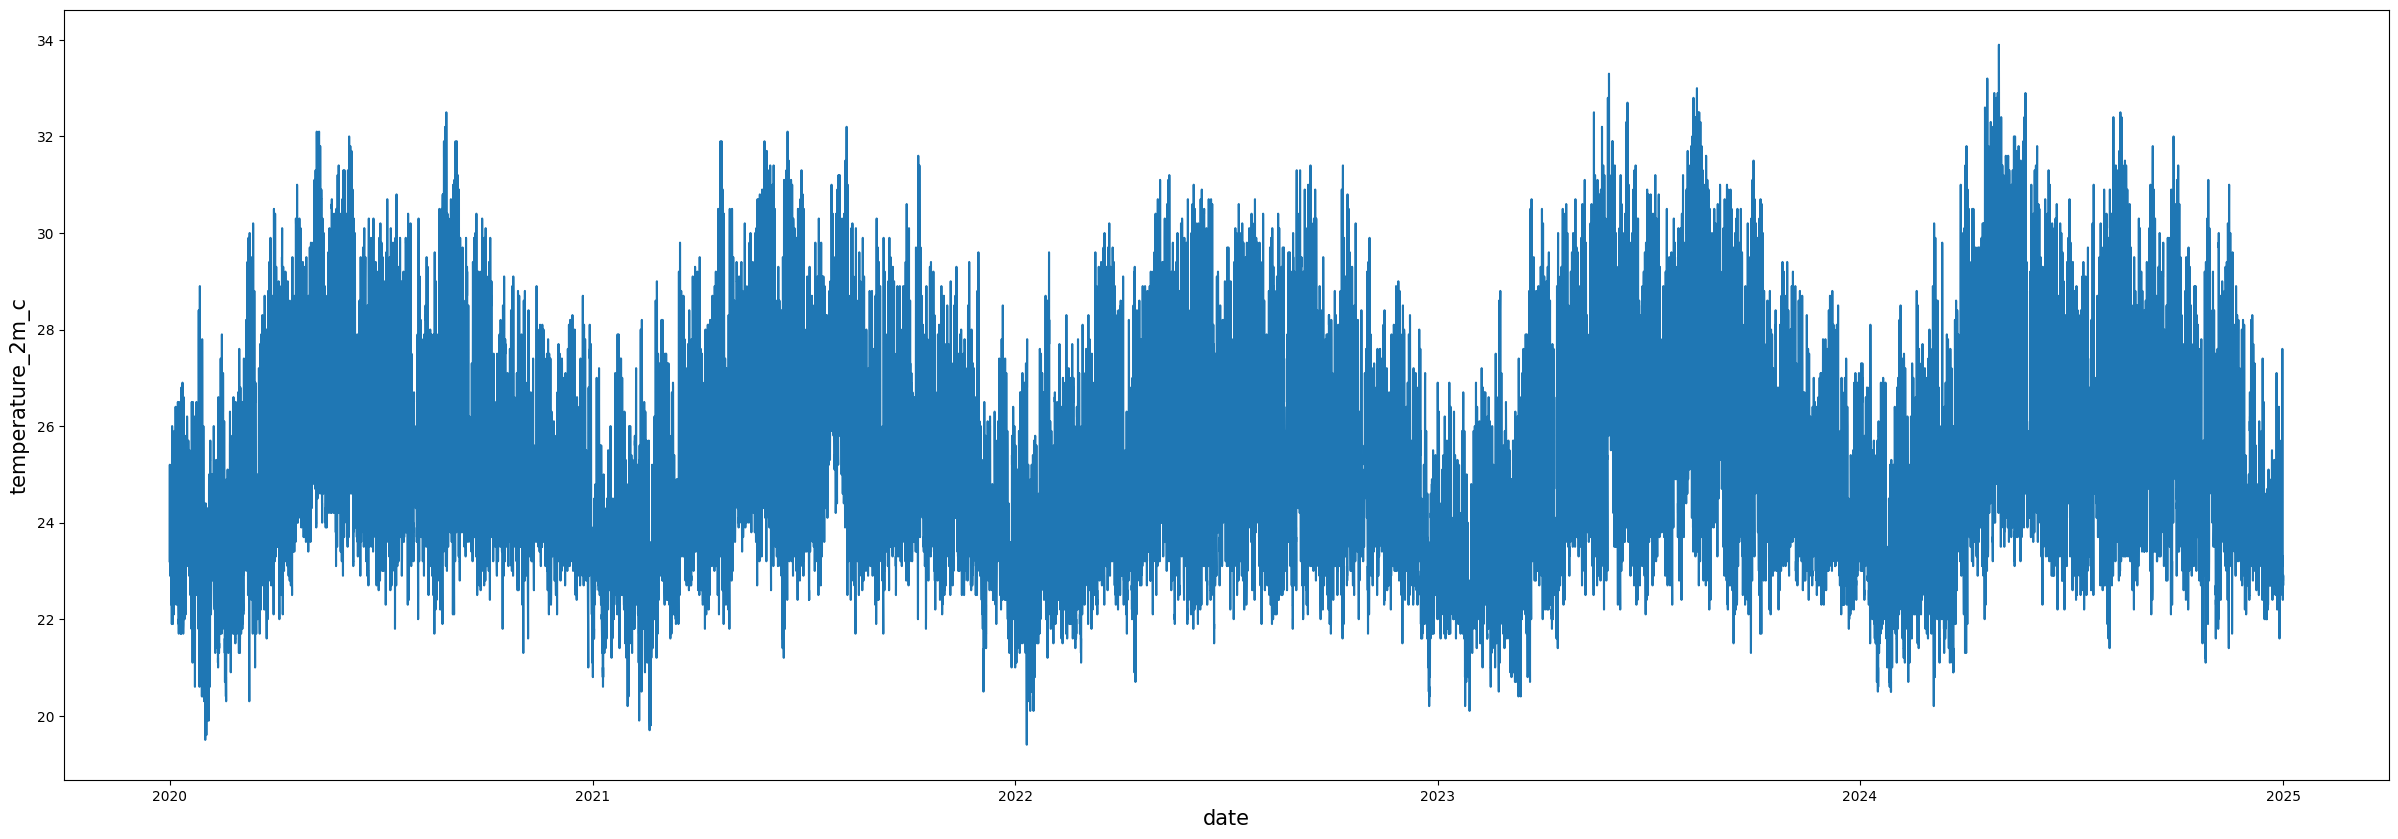

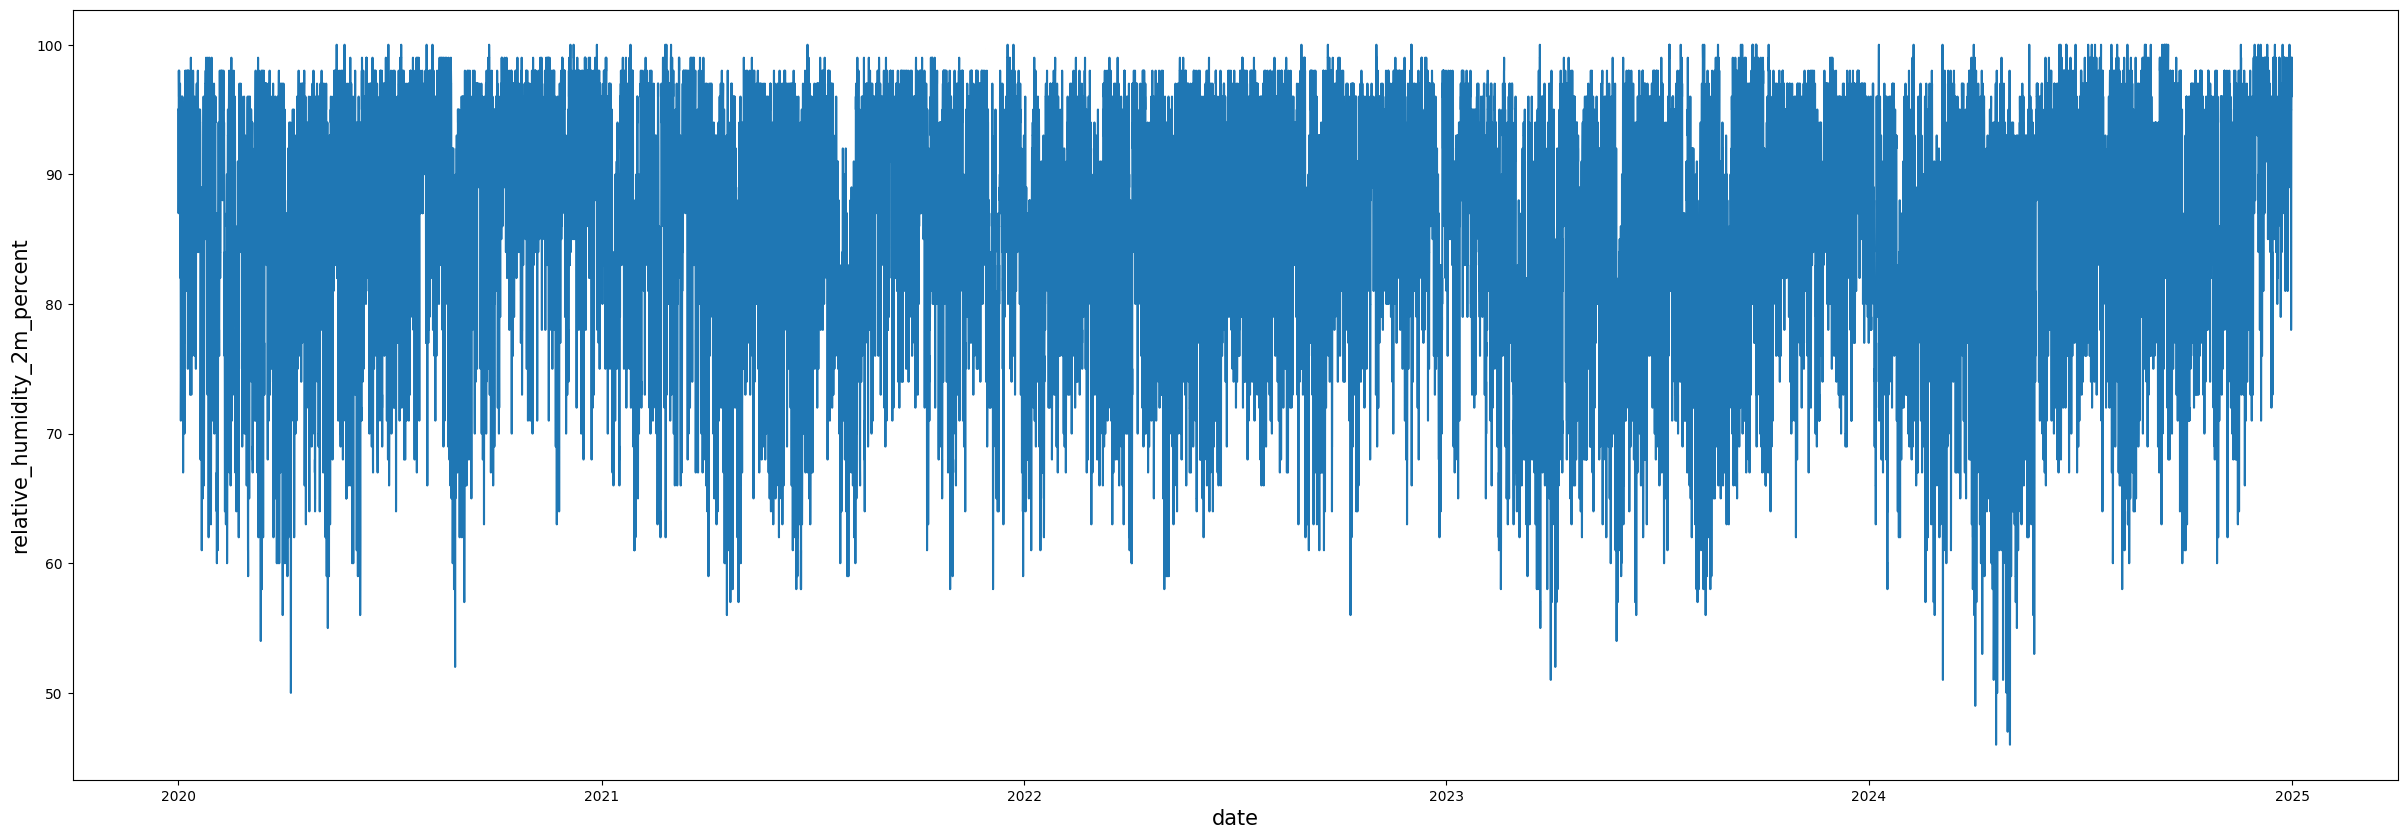

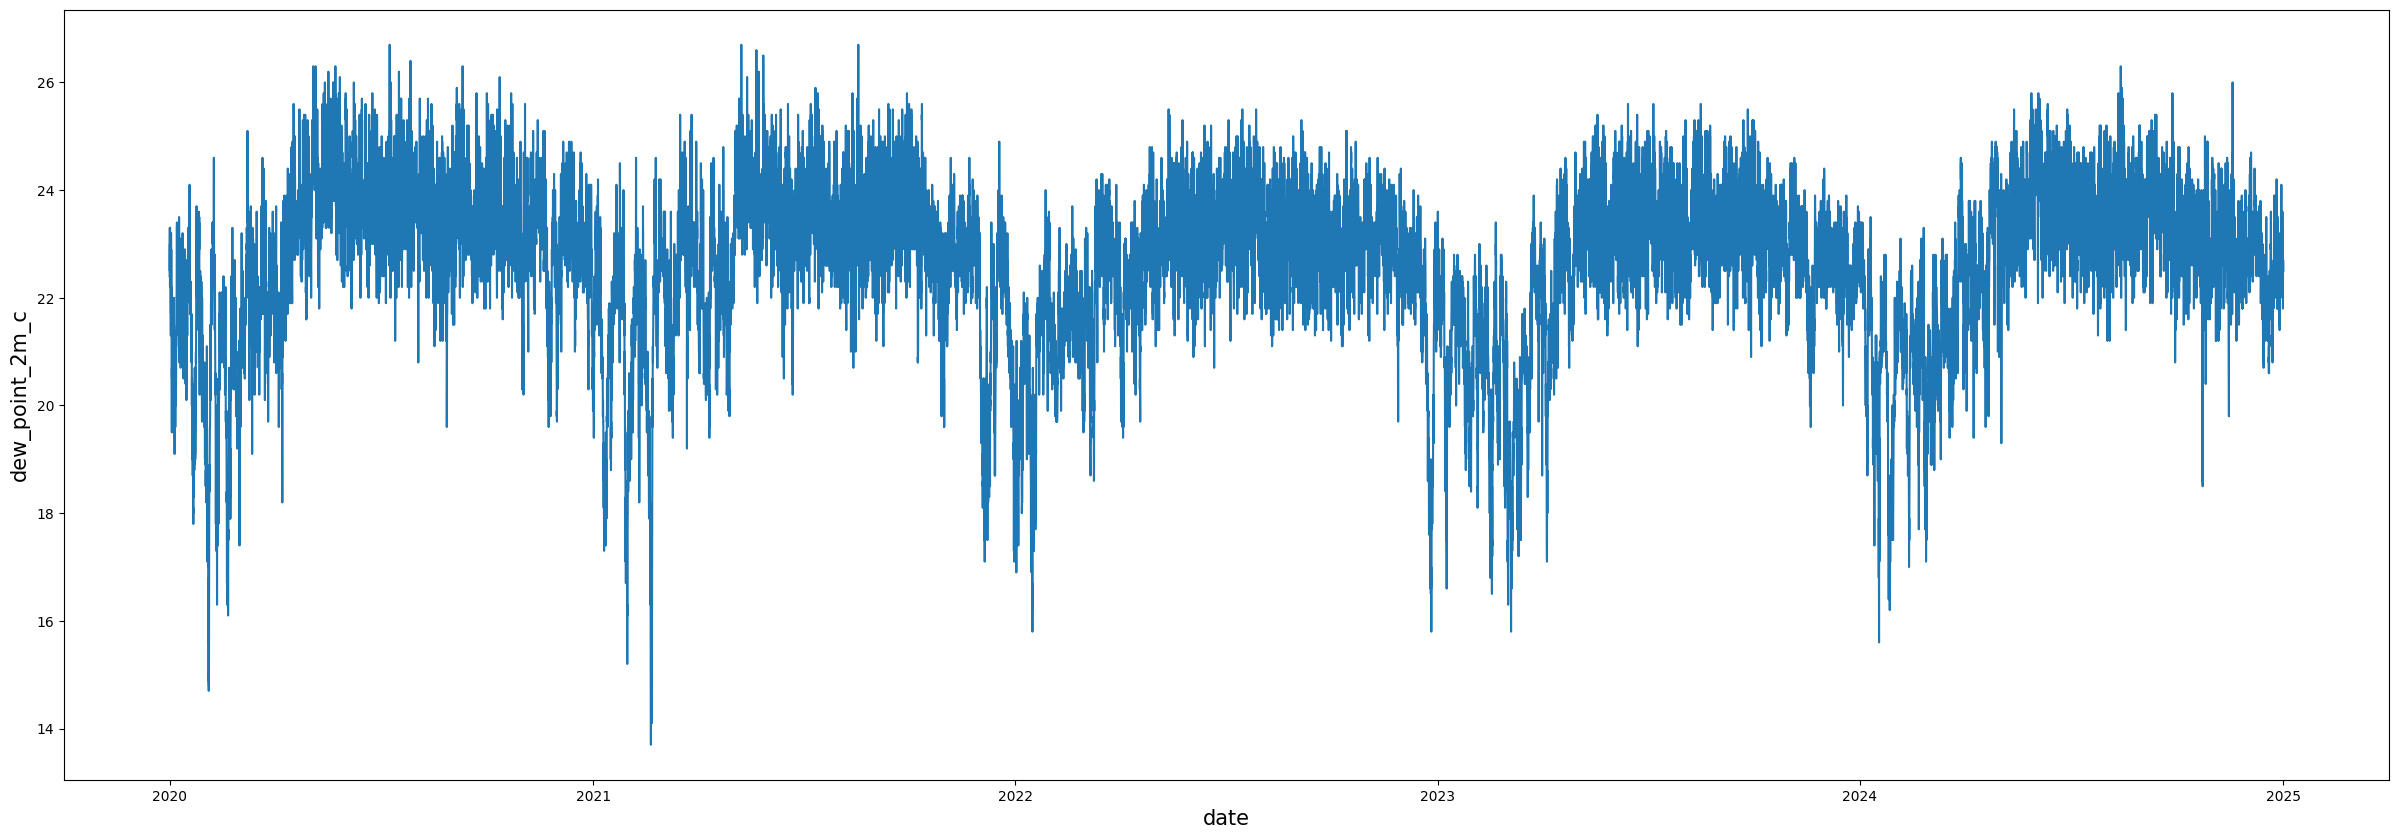

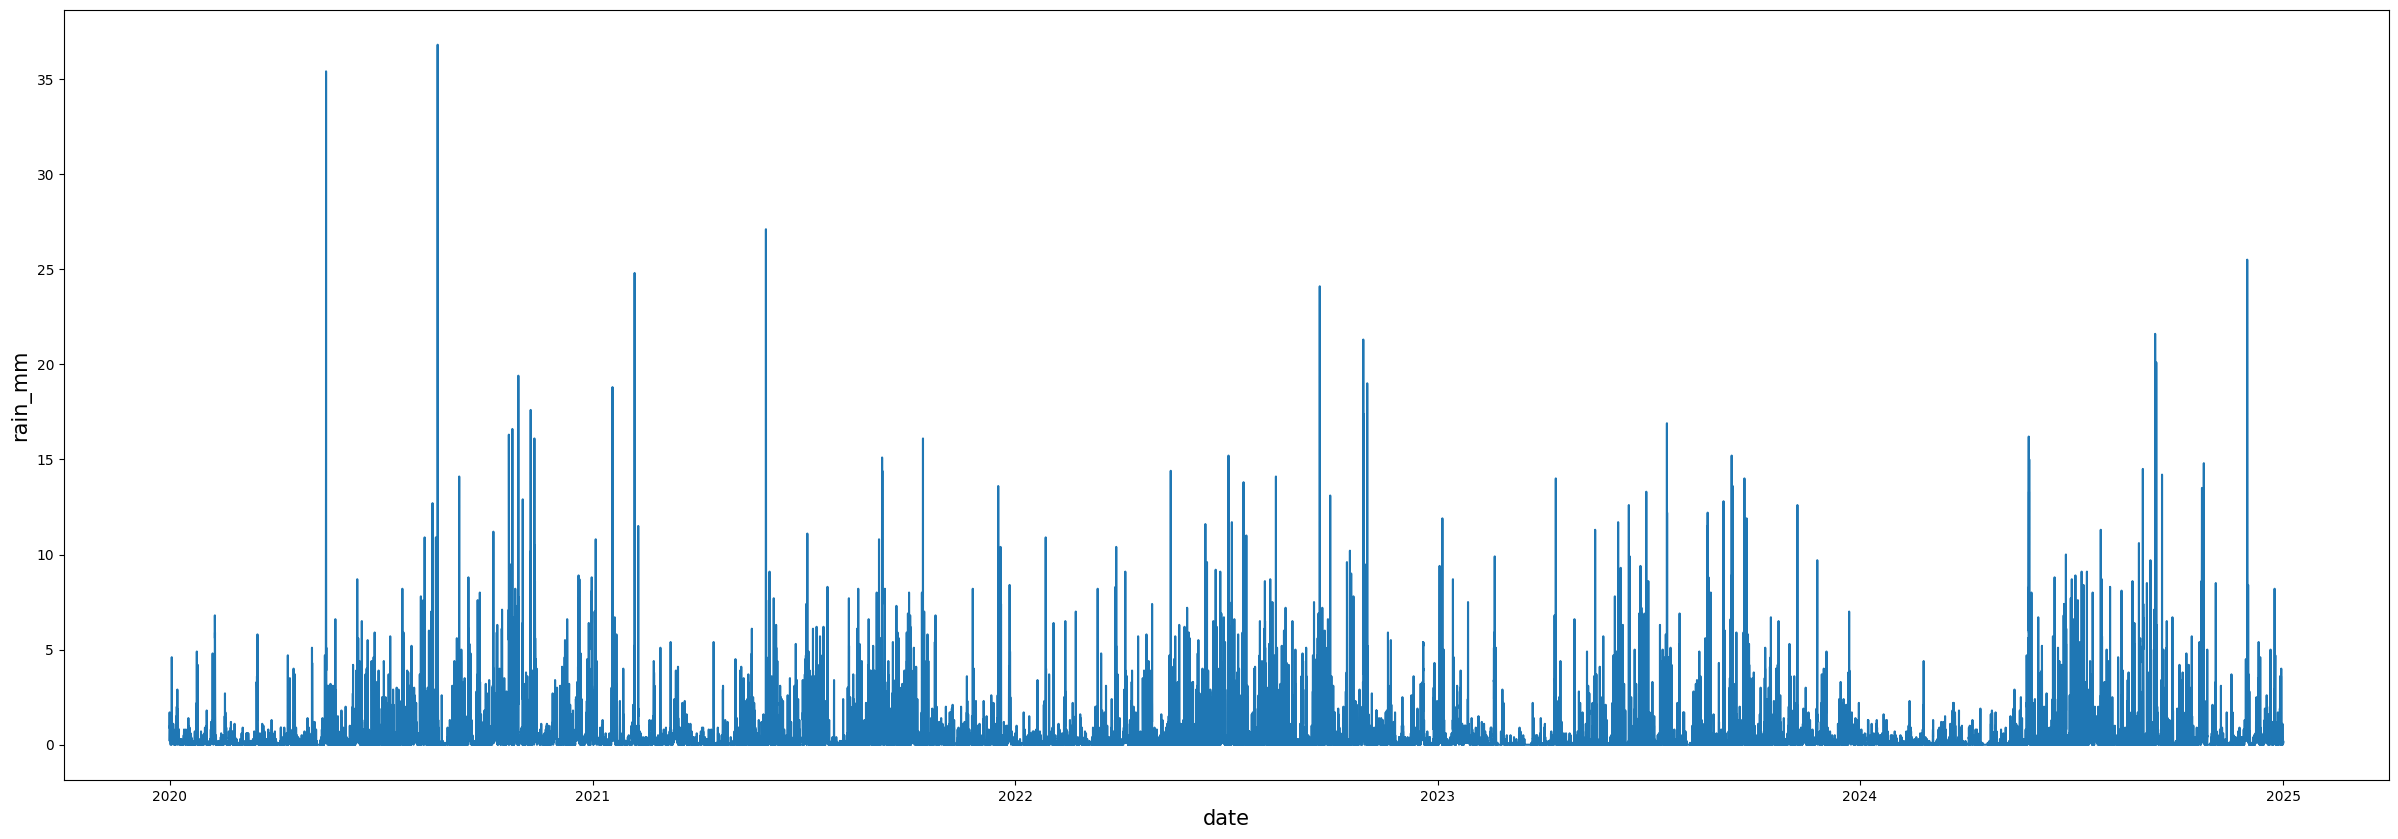

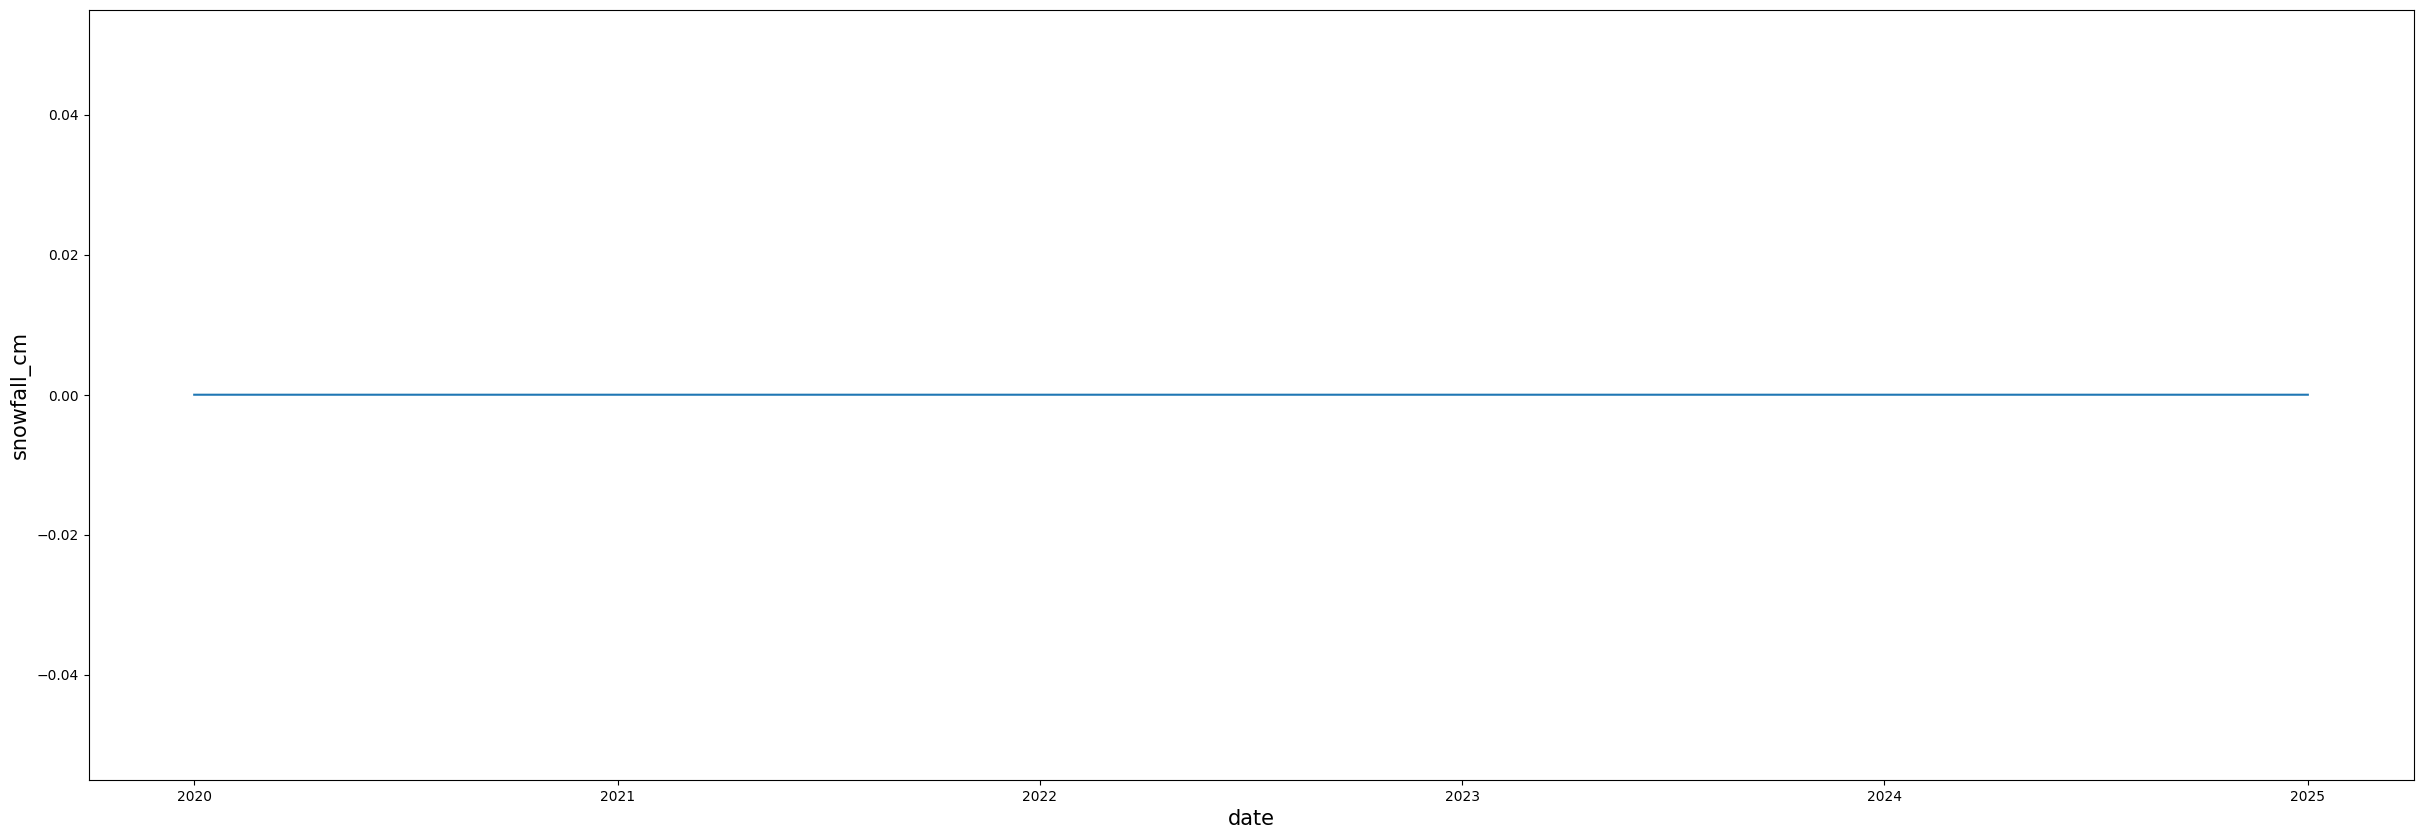

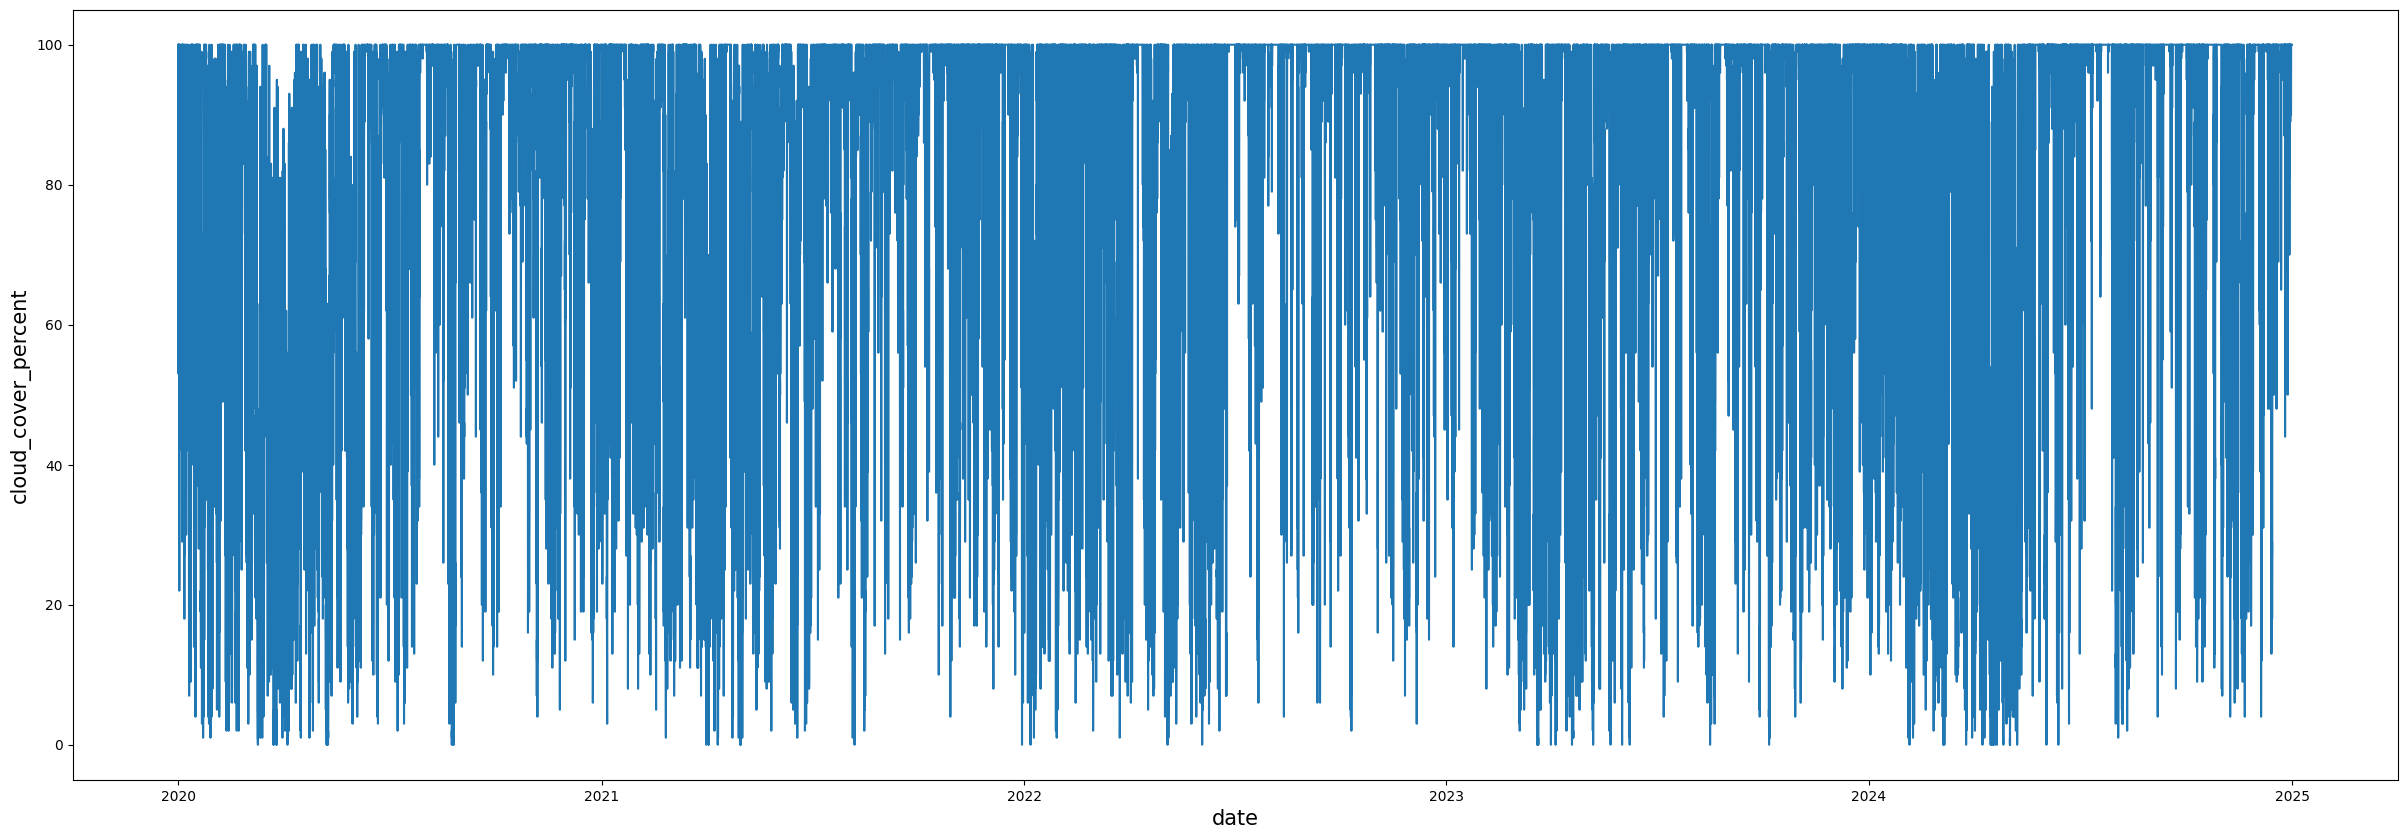

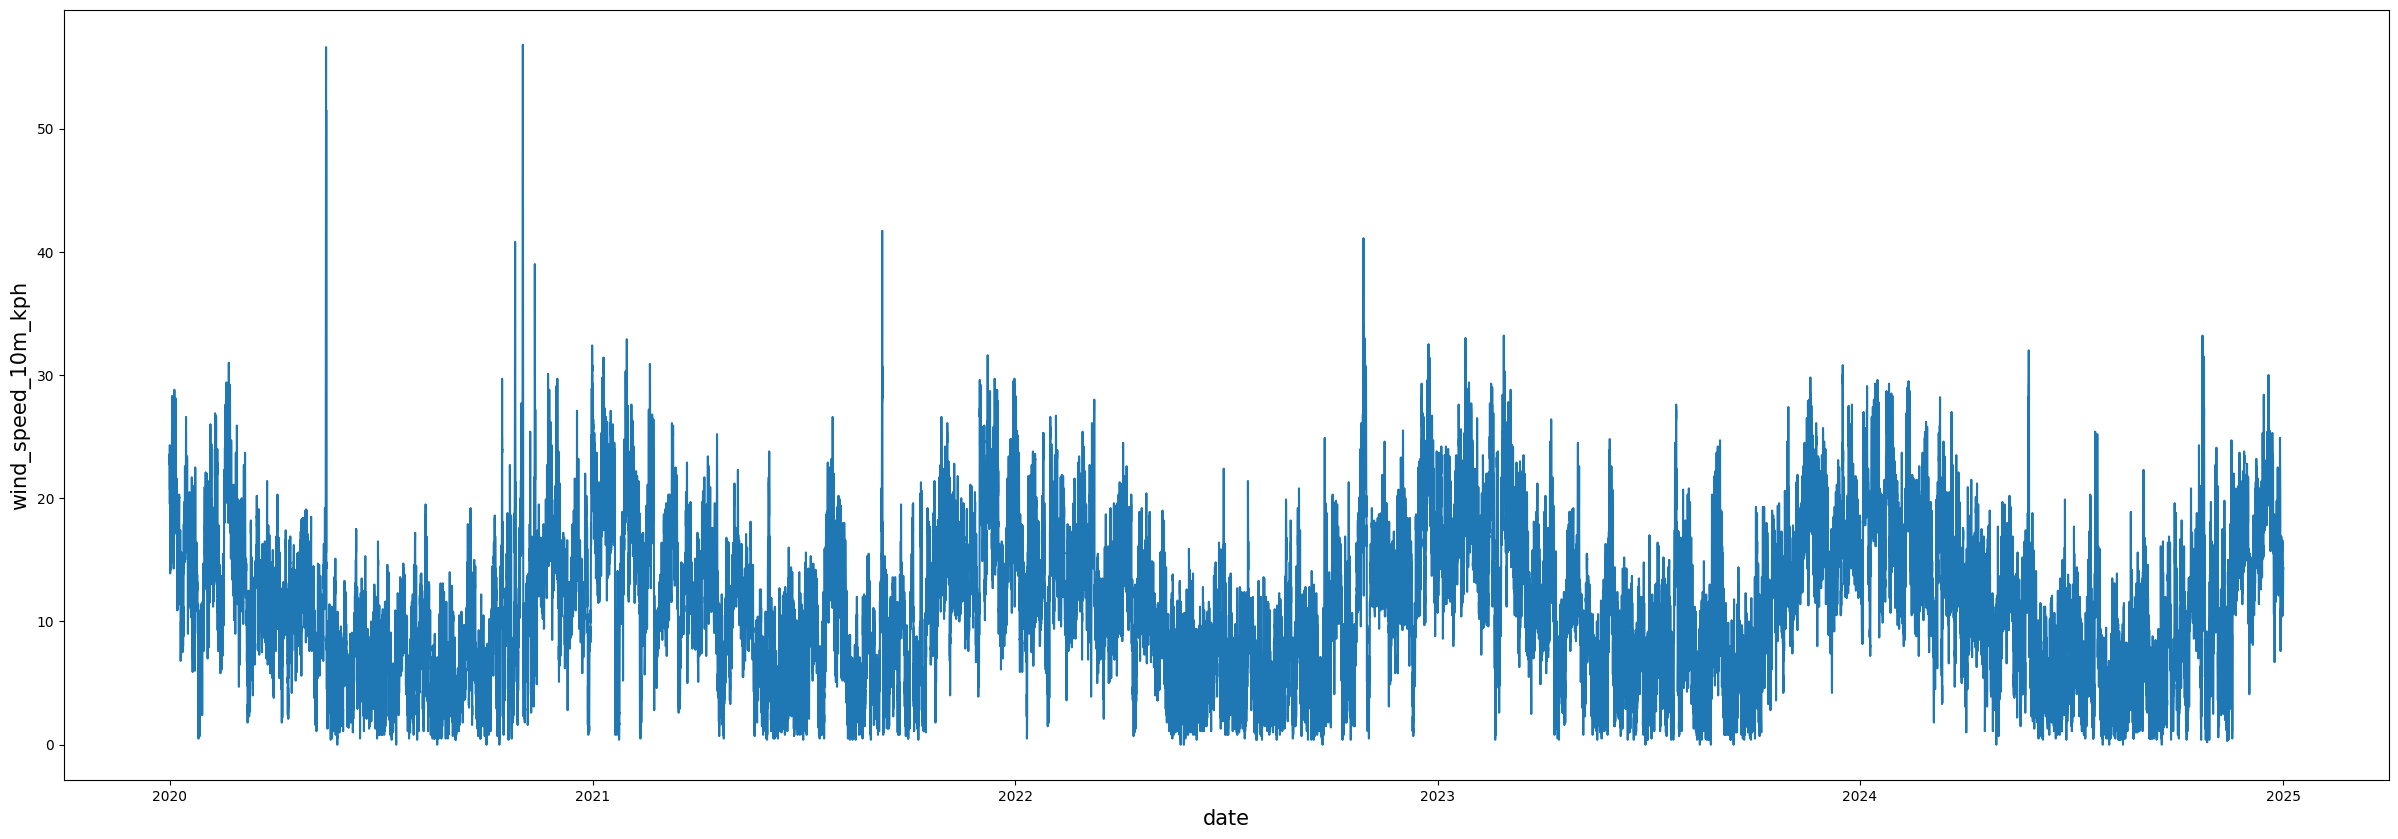

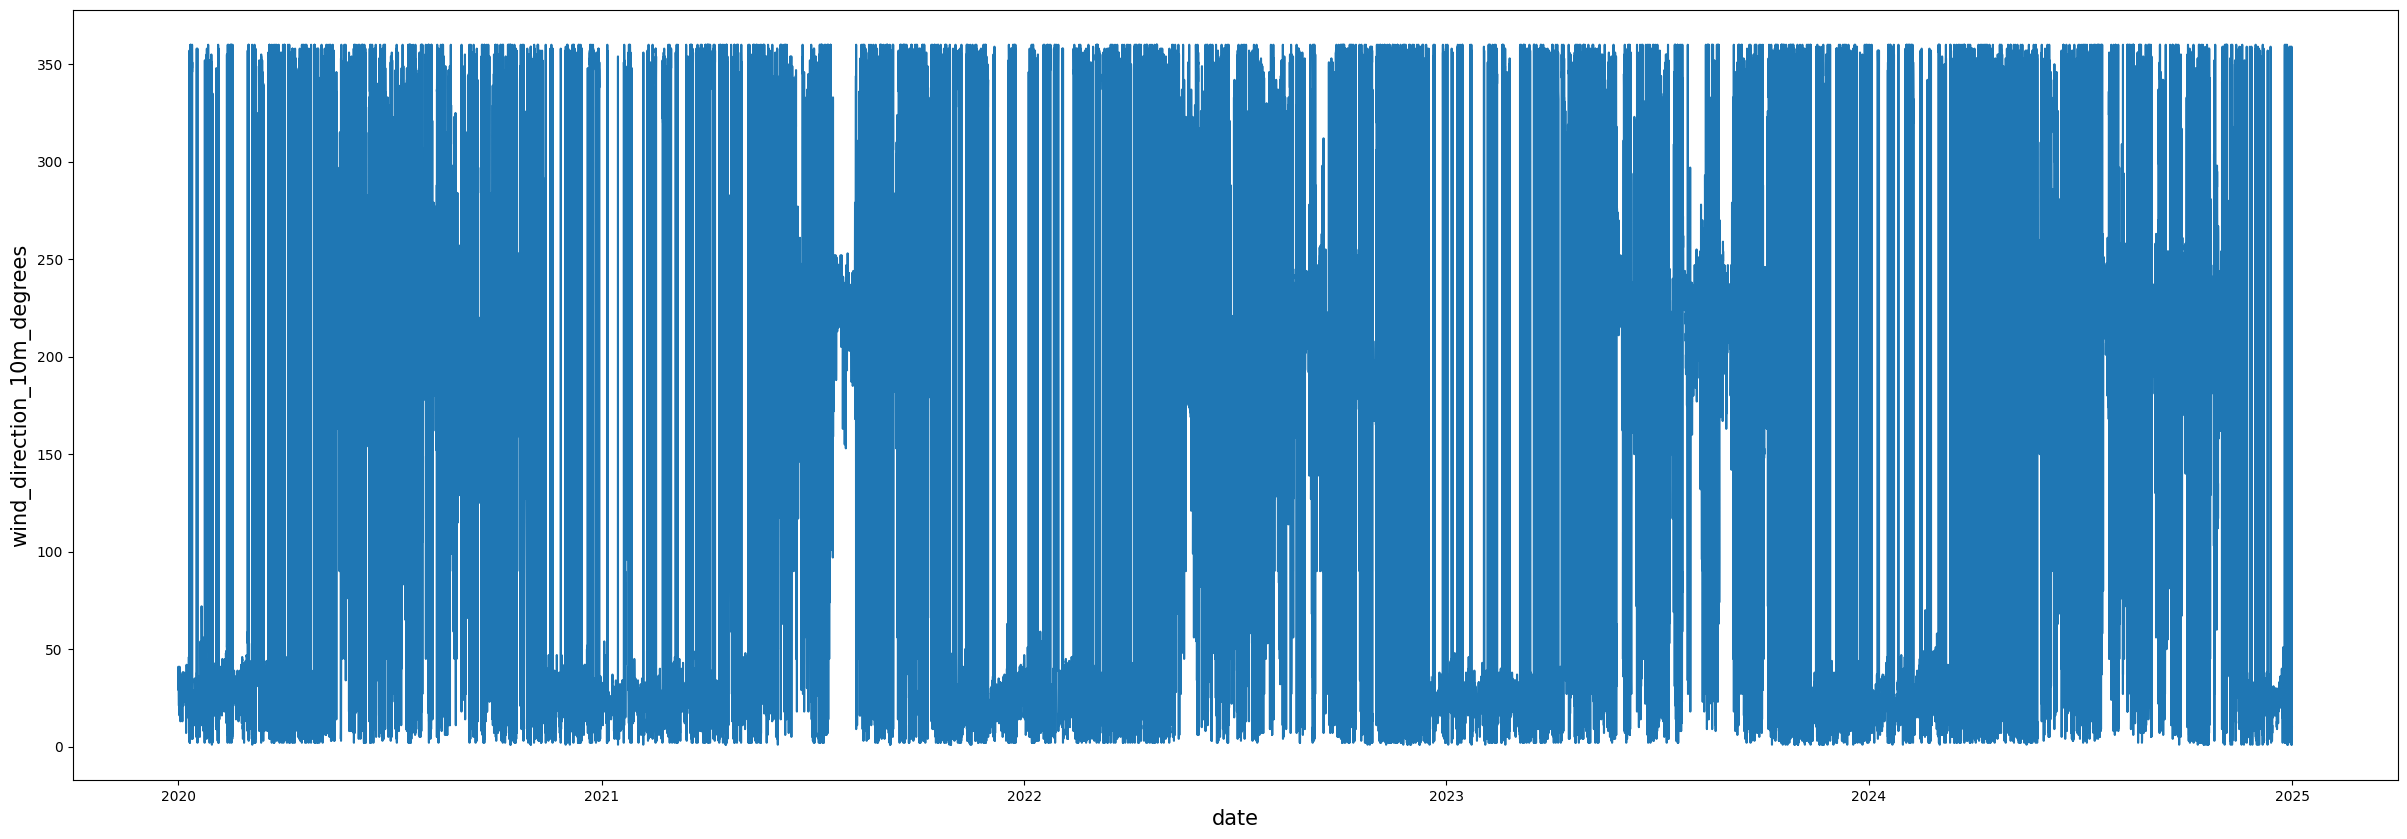

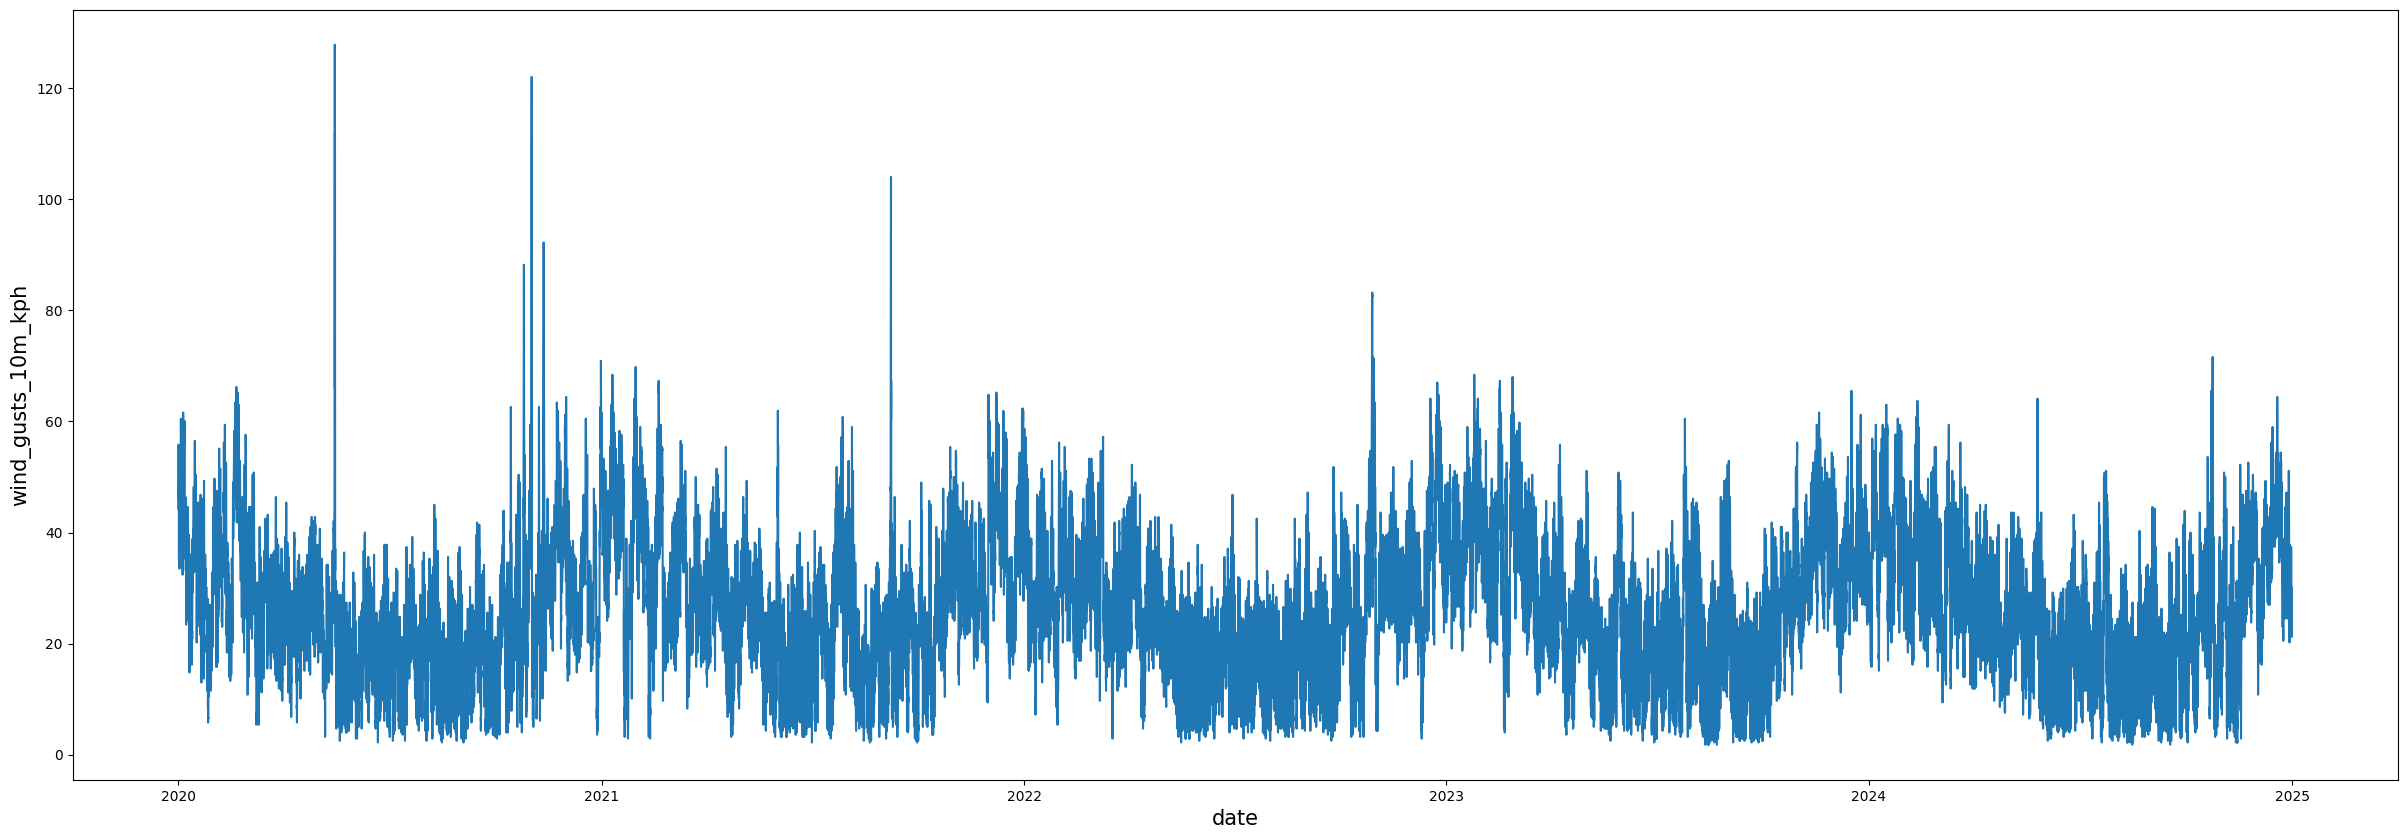

In [5]:
# Visualise the data
def visualize(data):
    for col in data.columns:
        plt.figure(figsize=(30, 10))
        plt.plot(data.index, data[col])
        plt.xlabel("date", fontsize=15)
        plt.ylabel(col, fontsize=15)
        plt.show()

visualize(weather_data)

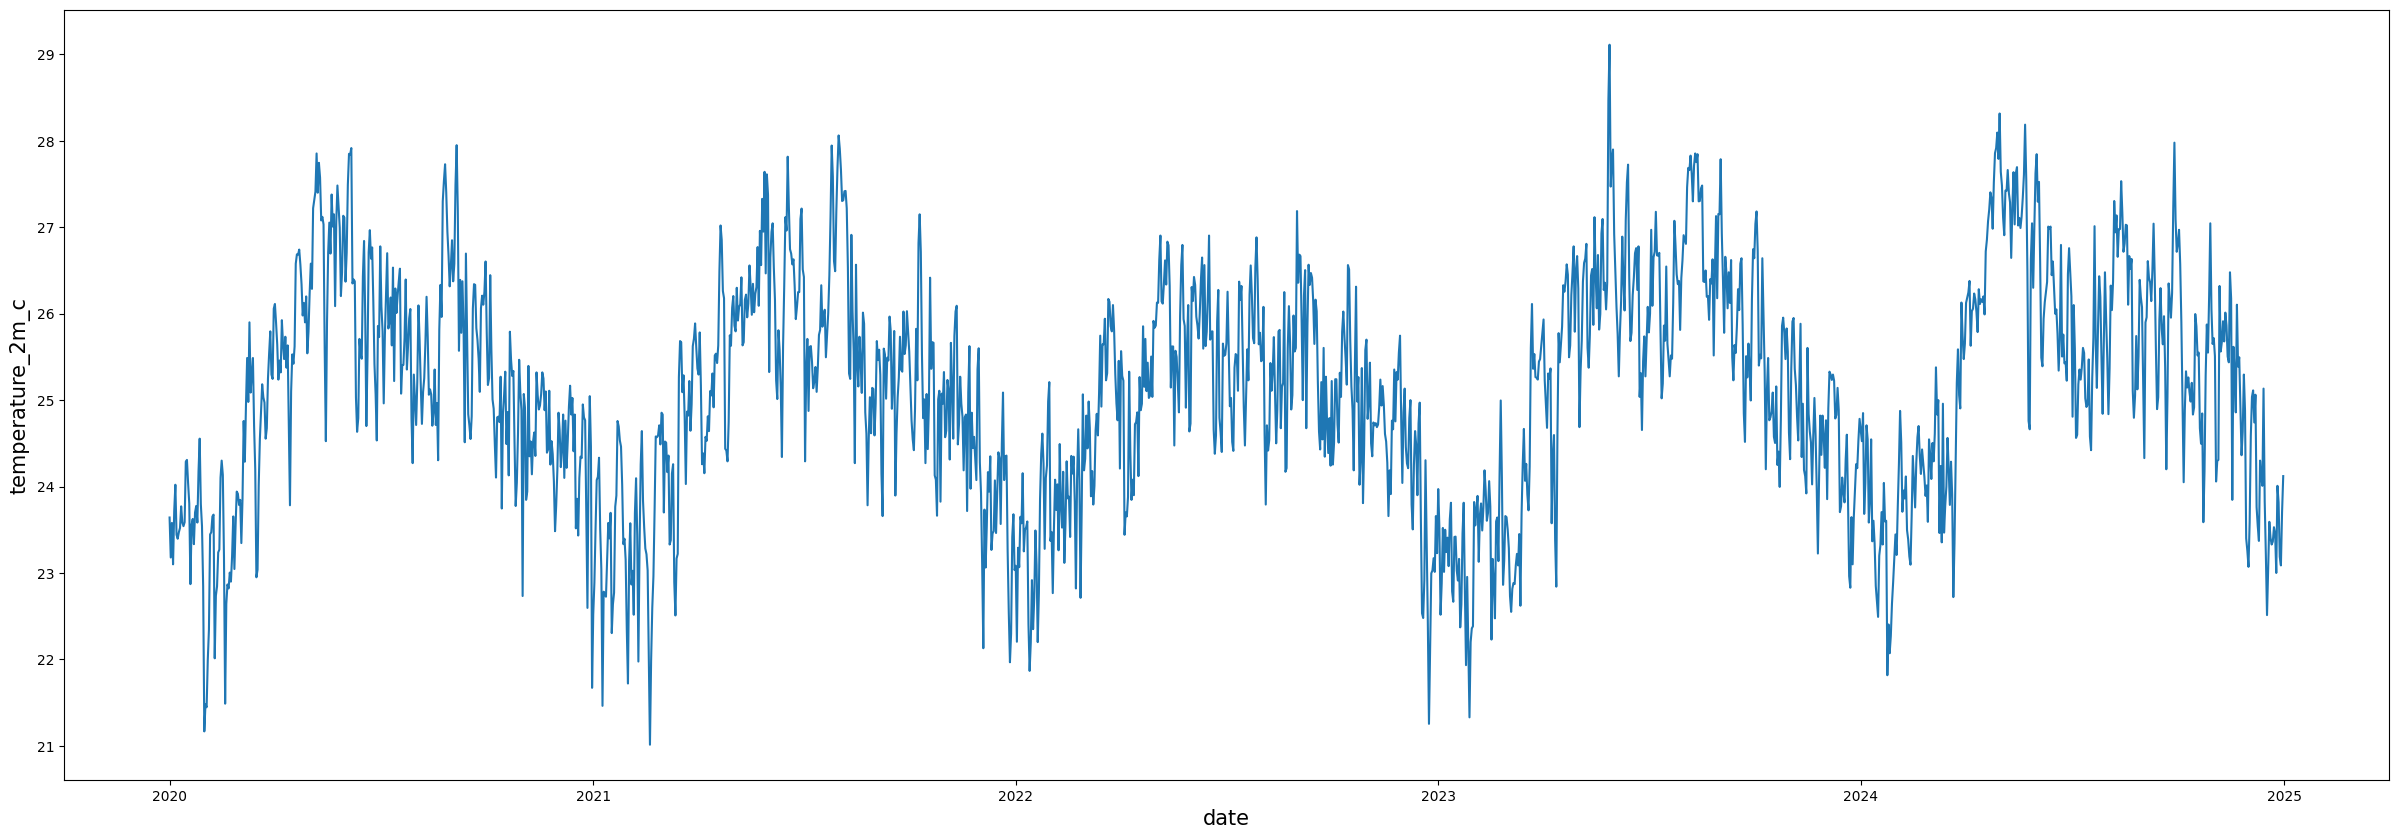

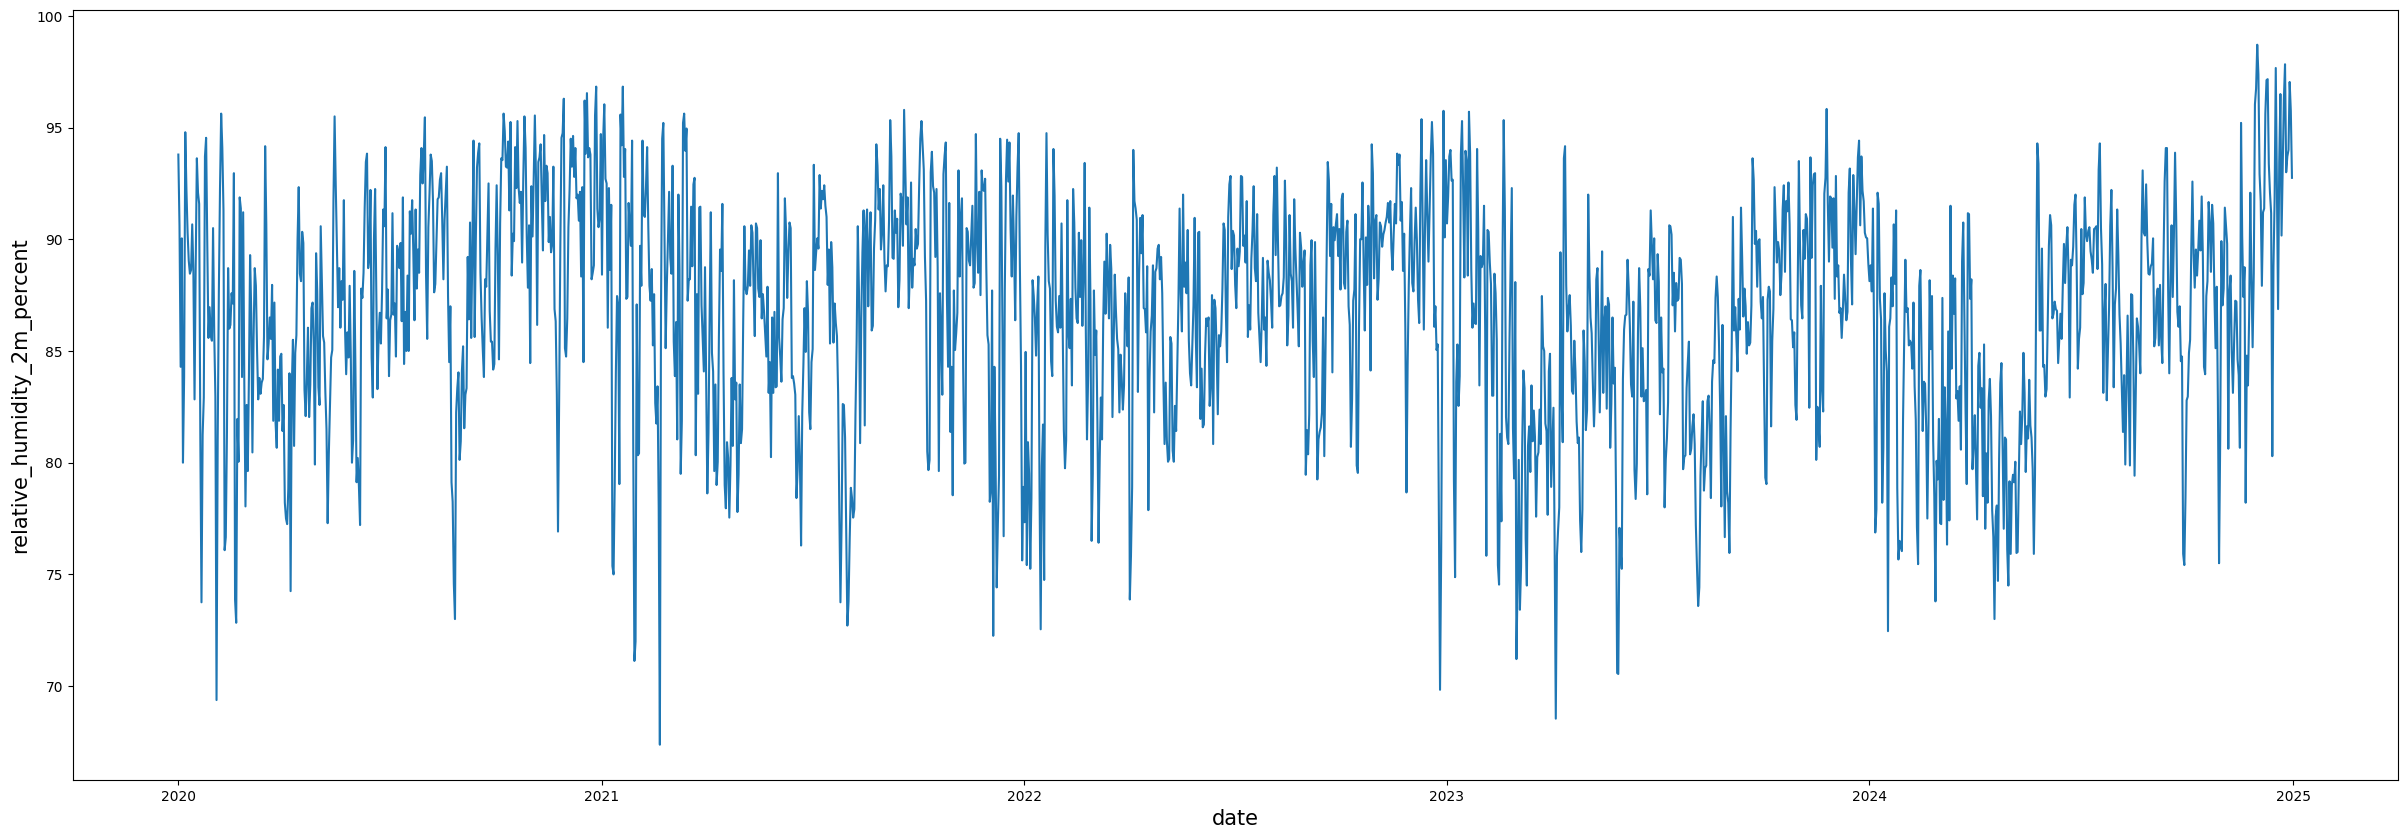

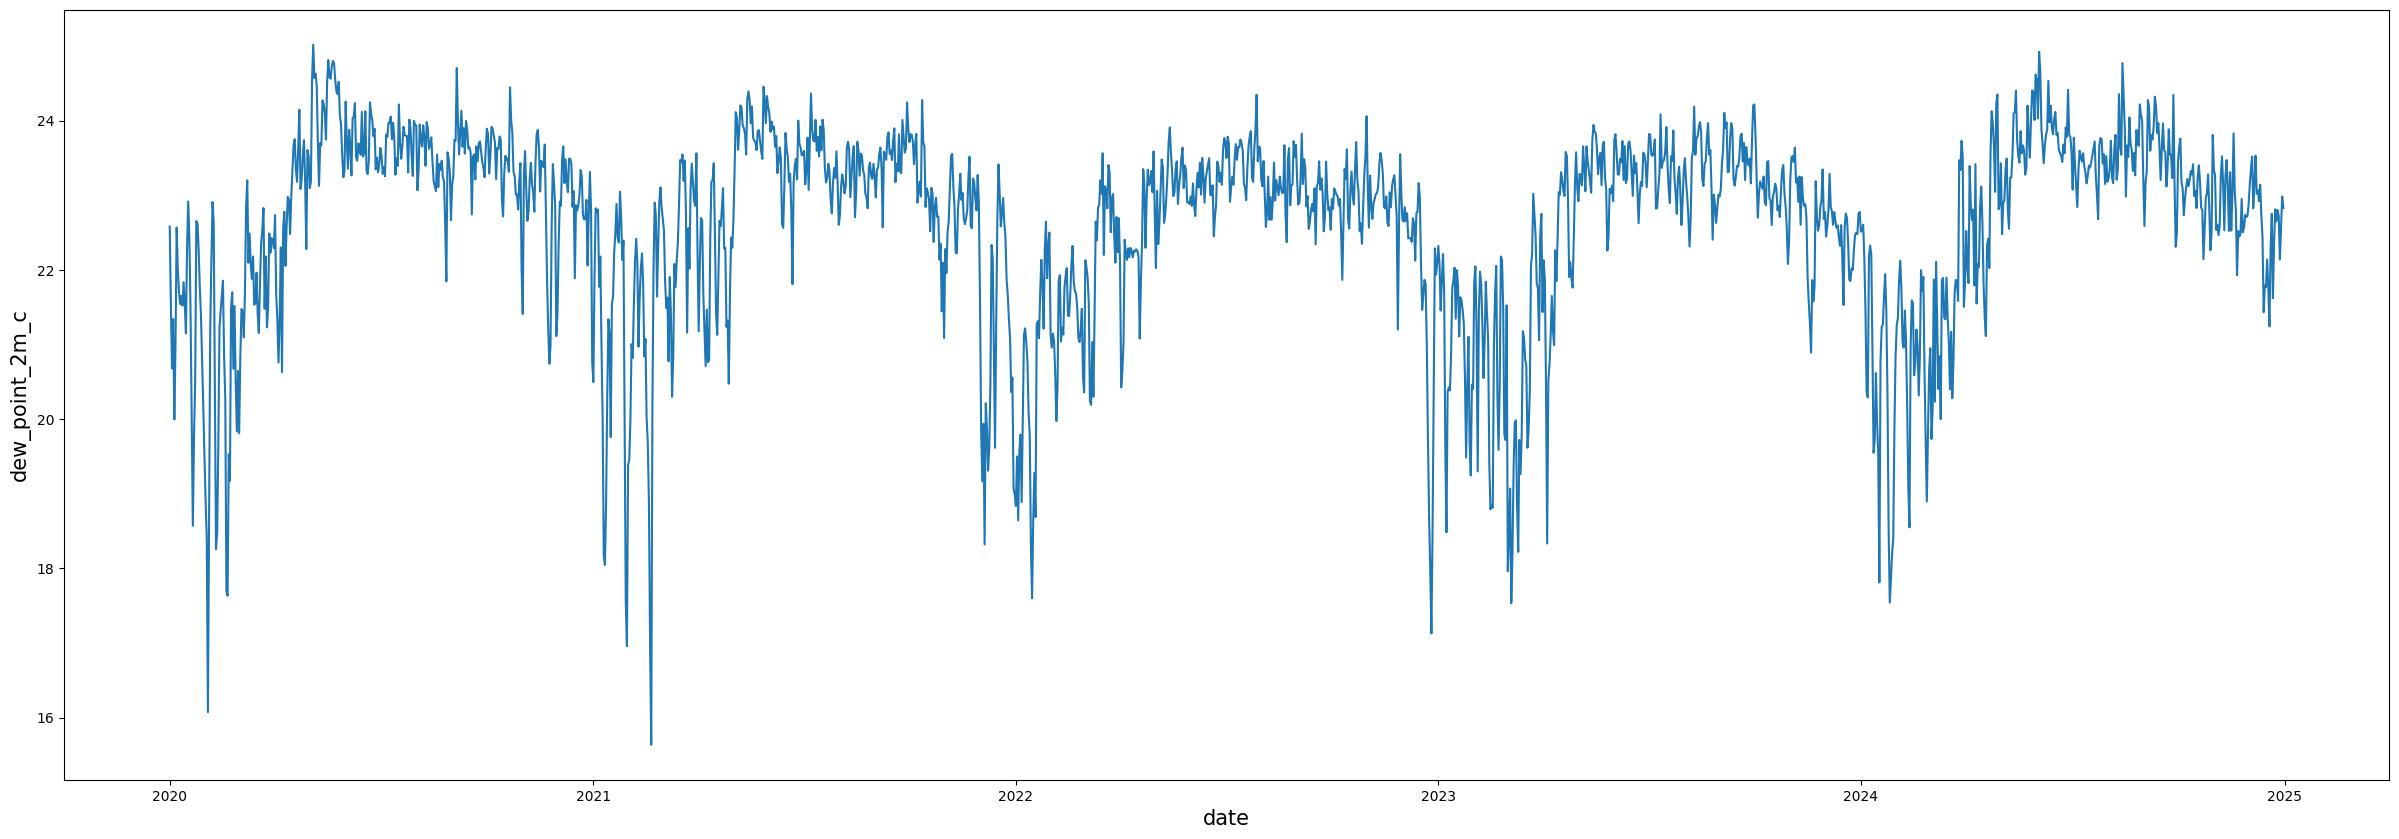

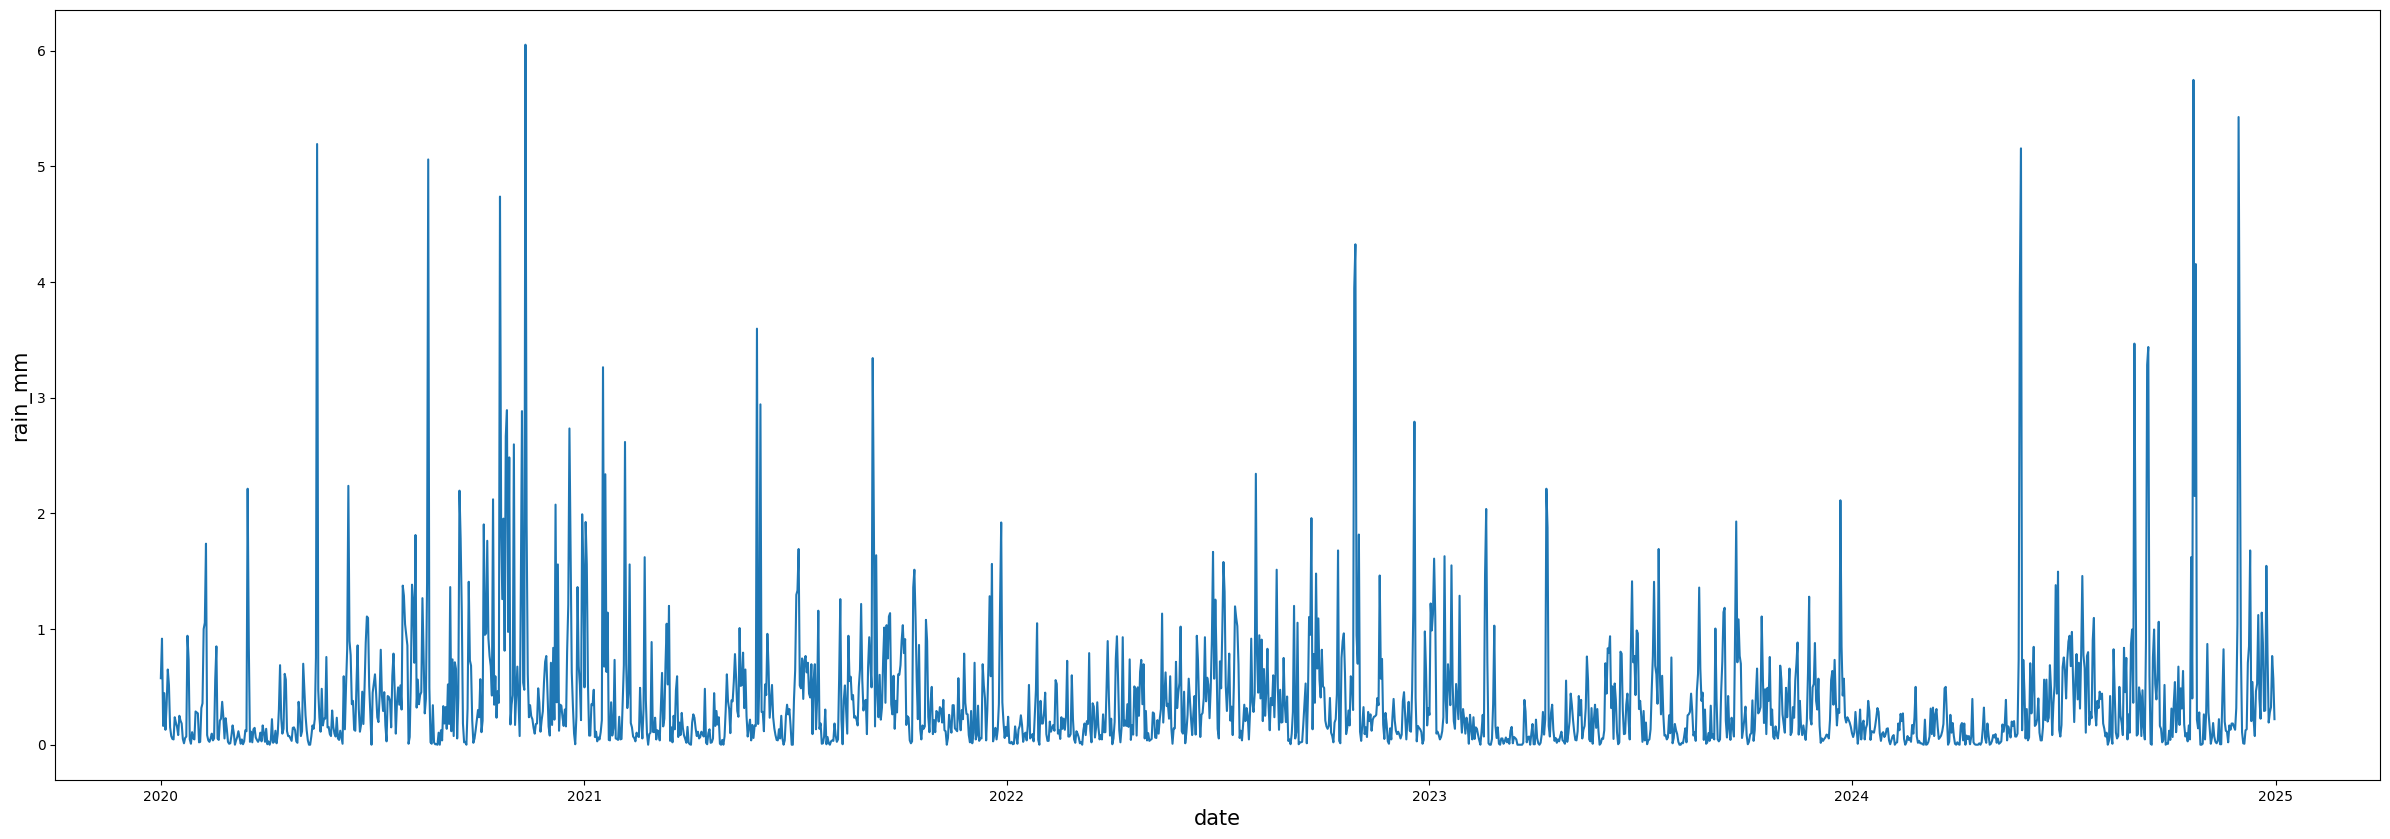

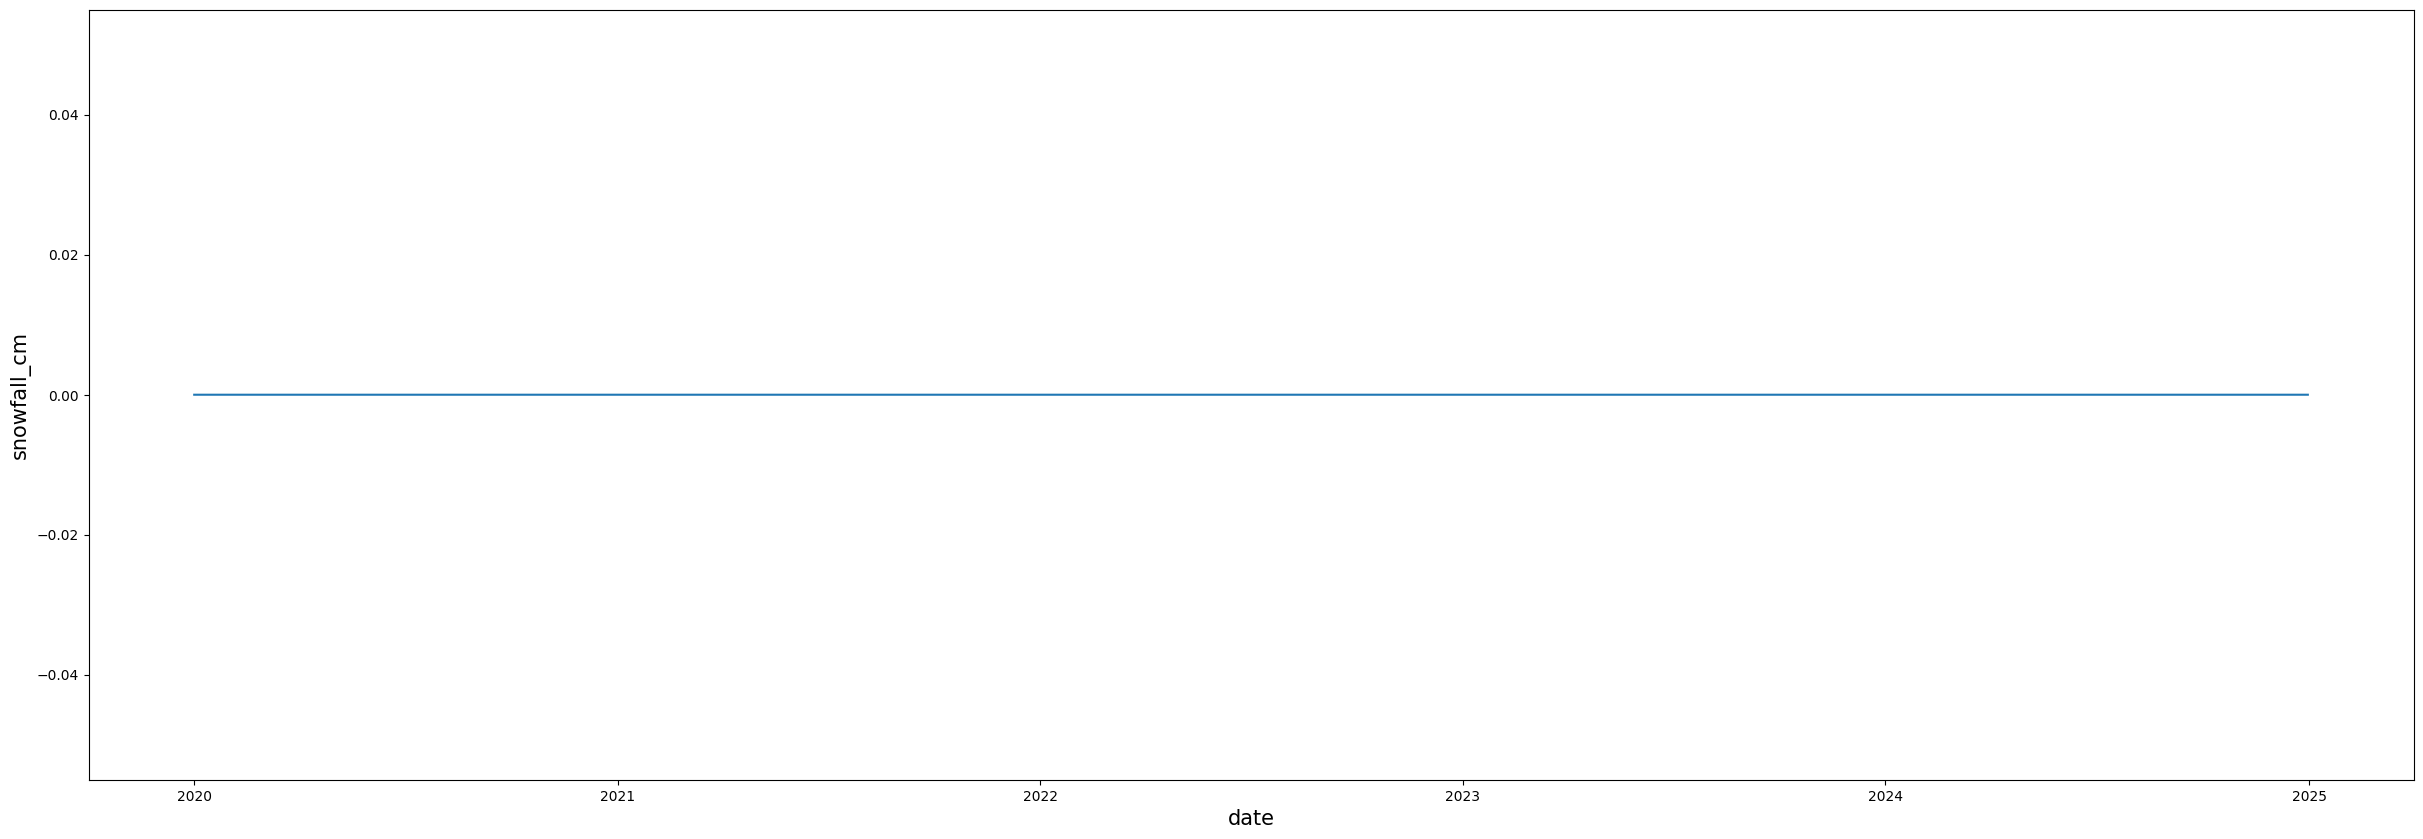

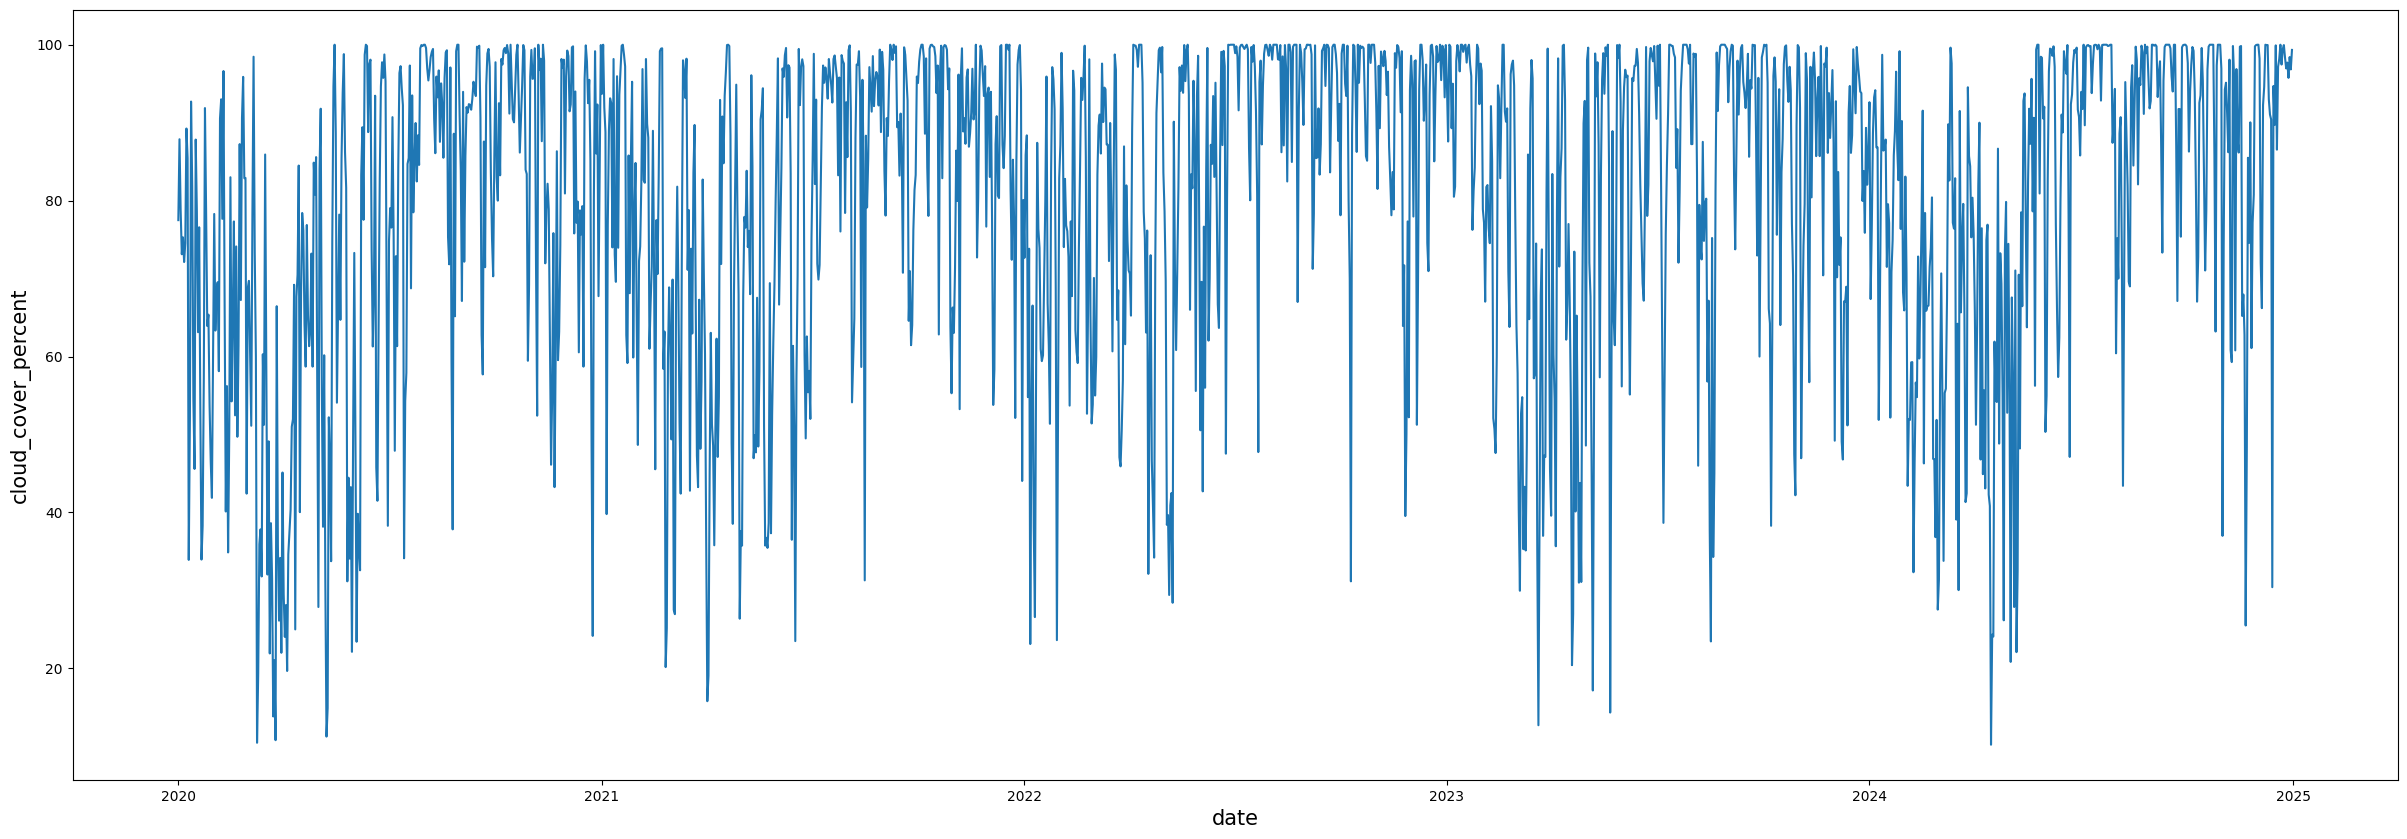

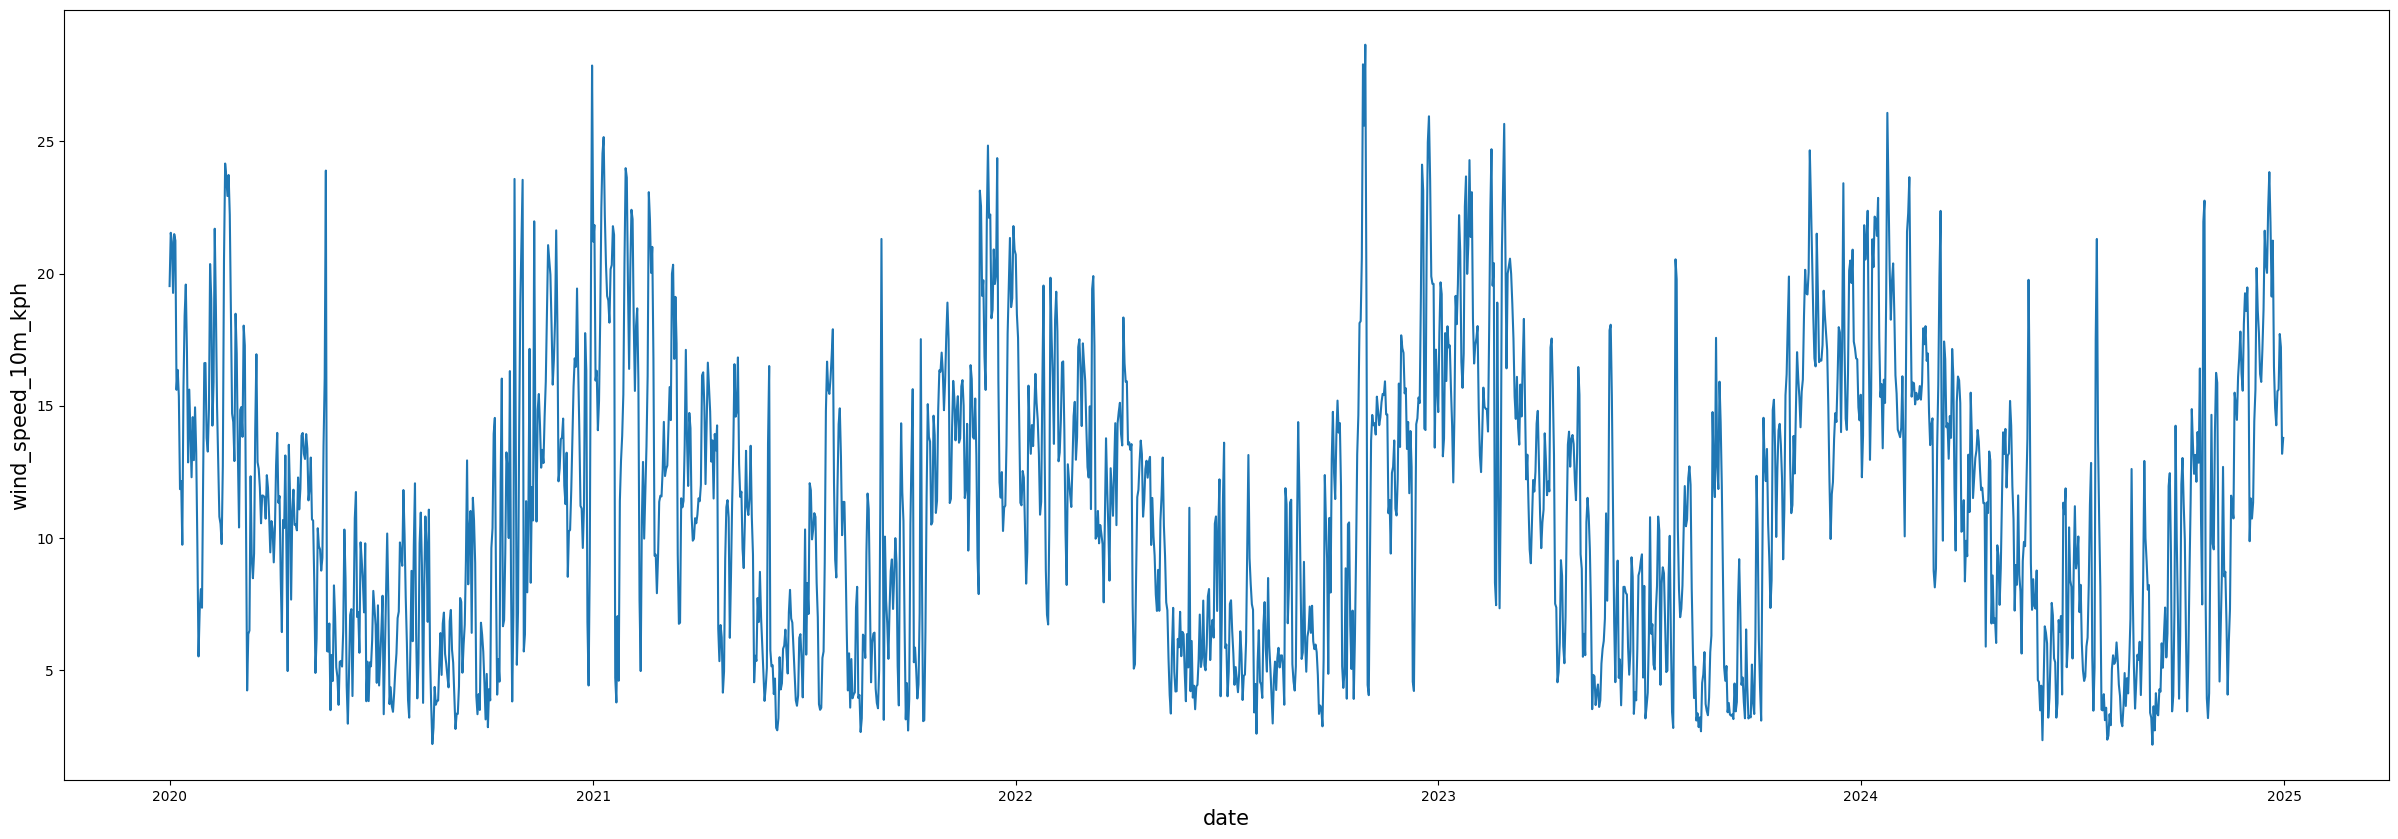

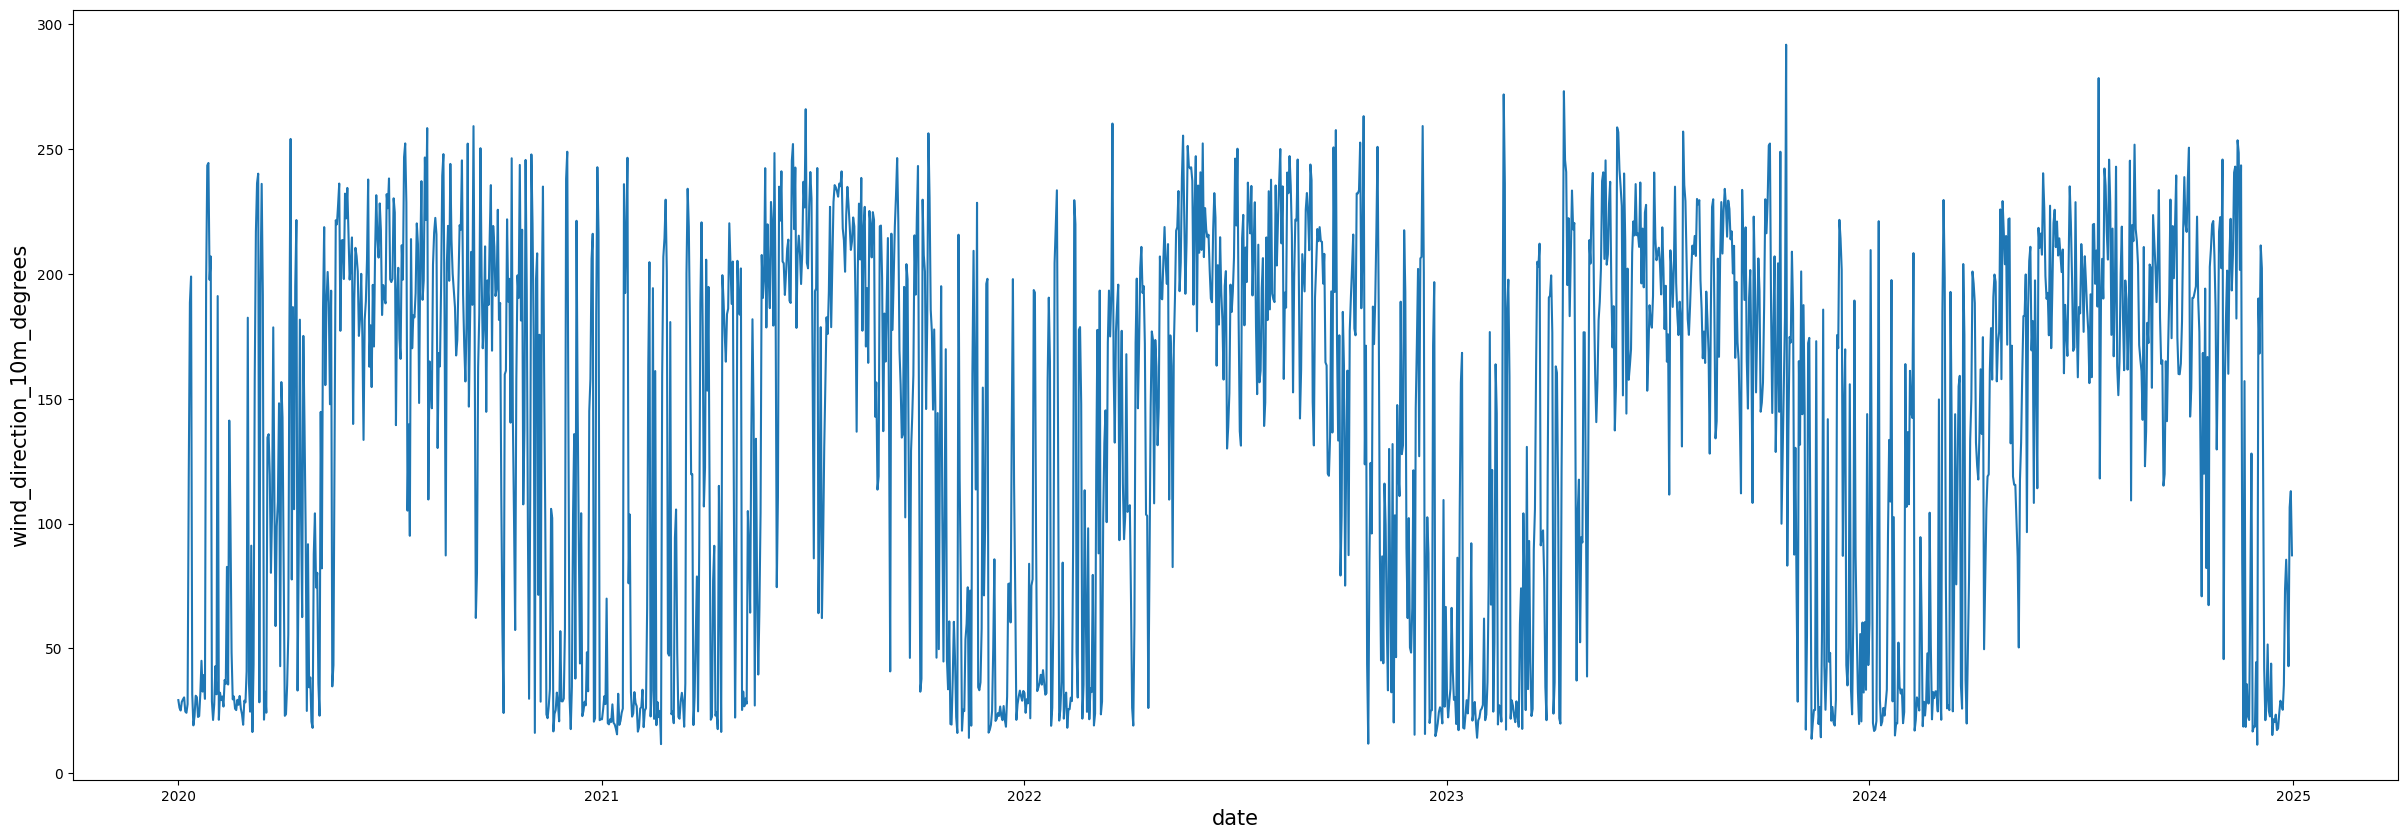

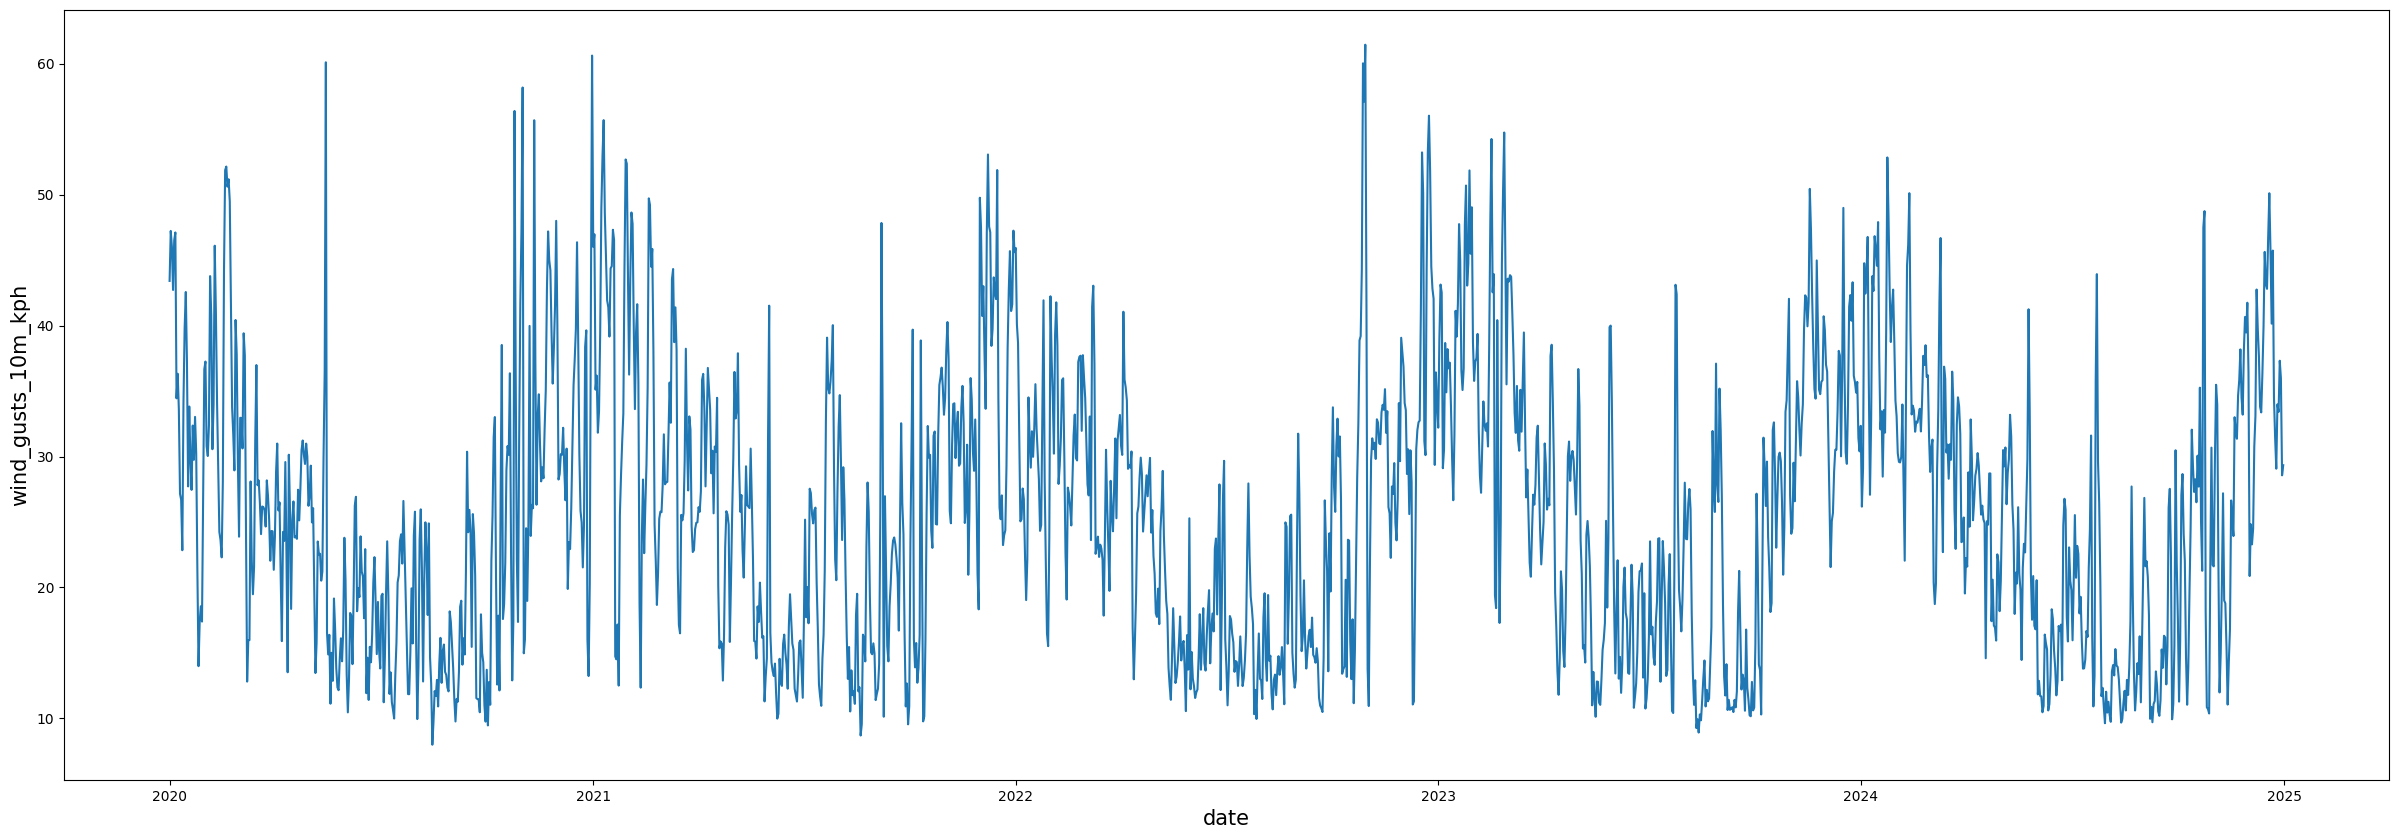

In [6]:
sample_daily = weather_data.resample("1D").mean()
visualize(sample_daily)

#### Notes

- Ask to identify location of the data
- Ask if its better to use daily or hourly data. Explain in what case its better.

In [7]:
def filter_data_on_date(data, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:

    return data.loc[start:end]


FEATURES = ["temperature_2m_c", "relative_humidity_2m_percent", "dew_point_2m_c", "cloud_cover_percent", "wind_speed_10m_kph", "wind_gusts_10m_kph"]
TARGET = "rain_mm"

training_data = filter_data_on_date(
    data=weather_data,
    start=datetime.datetime(2020, 1, 1),
    end=datetime.datetime(2020, 1, 31)
)

test_data = filter_data_on_date(
    data=weather_data,
    start=datetime.datetime(2020, 2, 1),
    end=datetime.datetime(2020, 2, 28)
)

training_data.head()

temperature_2m_c  relative_humidity_2m_percent  \
date_time                                                             
2020-01-01 00:00:00              23.2                            95   
2020-01-01 01:00:00              23.6                            95   
2020-01-01 02:00:00              24.4                            93   
2020-01-01 03:00:00              24.7                            88   
2020-01-01 04:00:00              25.1                            88   

                     dew_point_2m_c  rain_mm  snowfall_cm  \
date_time                                                   
2020-01-01 00:00:00            22.4      0.9          0.0   
2020-01-01 01:00:00            22.7      1.7          0.0   
2020-01-01 02:00:00            23.3      0.2          0.0   
2020-01-01 03:00:00            22.5      0.4          0.0   
2020-01-01 04:00:00            22.9      0.9          0.0   

                     cloud_cover_percent  wind_speed_10m_kph  \
date_time                                                      
2020-01-01 00:00:00                  100                19.6   
2020-01-01 01:00:00                   97                21.4   
2020-01-01 02:00:00                   92                21.0   
2020-01-01 03:00:00                   53                23.6   
2020-01-01 04:00:00                  100                22.7   

                     wind_direction_10m_degrees  wind_gusts_10m_kph  
date_time                                                            
2020-01-01 00:00:00                          36                44.3  
2020-01-01 01:00:00                          41                44.6  
2020-01-01 02:00:00                          35                45.0  
2020-01-01 03:00:00                          34                51.1  
2020-01-01 04:00:00                          29                53.6

In [8]:
# Make it a forcasting problem
training_data.loc[:,[TARGET]] = training_data[TARGET].shift(-1)
training_data = training_data.dropna()
test_data.loc[:,[TARGET]] = test_data[TARGET].shift(-1)
test_data = test_data.dropna()

In [9]:
# Separate our x and y
x_train, y_train = training_data[FEATURES], training_data[TARGET]
x_test, y_test = test_data[FEATURES], test_data[TARGET]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
# Create matrix optimized for xgboost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Define parameters for model
params = {
    "objective": "reg:squarederror", # regression,
    "eval_metric": "rmse",
    "learning_rate": 0.01,
    "max_depth": 11
}

model = xgb.train(params, dtrain, num_boost_round=100)

In [11]:
# Doing the prediction
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.3f}")

RMSE: 0.631


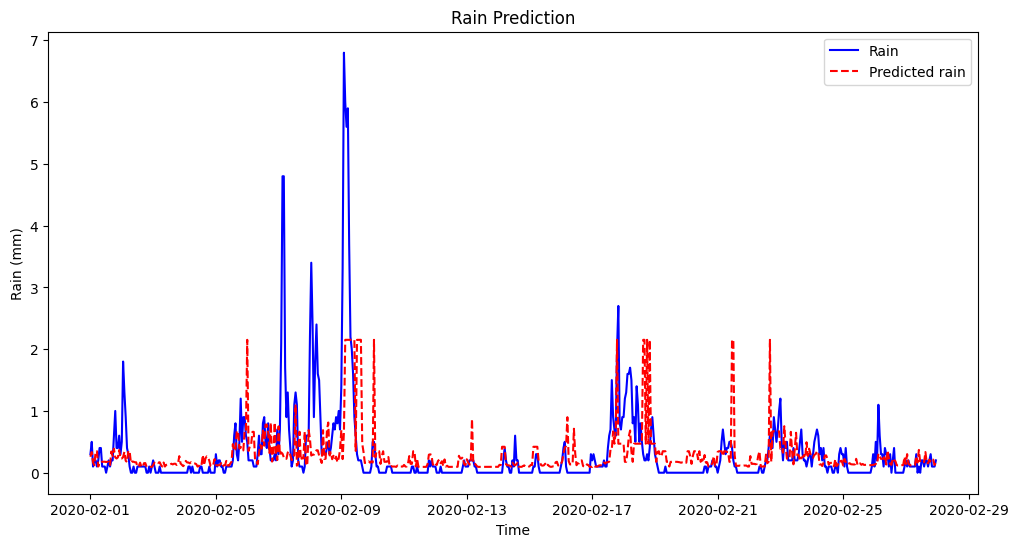

In [12]:
def show_scores(ytest, ypred):
    plt.figure(figsize=(12, 6))
    plt.plot(ytest.index, ytest, label="Rain", color="blue")
    plt.plot(ytest.index, ypred, label="Predicted rain", color="red", linestyle="dashed")
    plt.xlabel("Time")
    plt.ylabel("Rain (mm)")
    plt.legend()
    plt.title("Rain Prediction")
    plt.show()

show_scores(y_test, y_pred)

In [13]:
def get_monthly_dates(start_year: int, start_month: int, years: int = 20):
    start_date = datetime.datetime(start_year, start_month, 1)
    end_date = start_date + datetime.timedelta(days=years * 365)  # Approximate end date
    date_range = pd.date_range(start=start_date, end=end_date, freq="MS")  # Month start dates

    result = []
    for date in date_range:
        start_of_month = date
        next_month = date + pd.DateOffset(months=1)
        end_of_month = next_month - datetime.timedelta(days=1)  # Last day of the month
        result.append((start_of_month, end_of_month))

    return result

In [21]:
def get_scoring(target_model, dates: list):
    scoring = []
    for start, end in dates:
        _test_data = filter_data_on_date(
            data=weather_data,
            start=start,
            end=end
        )
    
        _test_data.loc[:,[TARGET]] = _test_data[TARGET].shift(-1)
        _test_data = _test_data.dropna()
        _x_test, _y_test = _test_data[FEATURES], _test_data[TARGET]
        _x_test = scaler.transform(_x_test)
    
        _dtest = xgb.DMatrix(_x_test, label=_y_test)
    
        _y_pred = target_model.predict(_dtest)
        _rmse = np.sqrt(mean_squared_error(_y_test, _y_pred))
        _r2_score = r2_score(_y_test, _y_pred)
    
        scoring.append({"date": start, "mse": _rmse, "r2": _r2_score})

    return pd.DataFrame(scoring)
    
to_test_dates = get_monthly_dates(2021, 1, 4)
scores_df = get_scoring(model, to_test_dates)

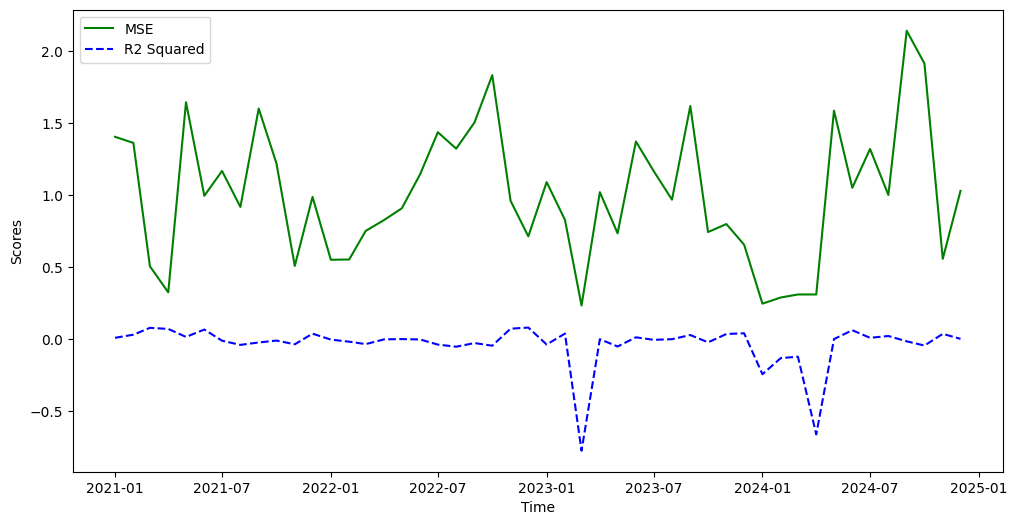

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(scores_df.date, scores_df.mse, label="MSE", color="green")
plt.plot(scores_df.date, scores_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Scores")
plt.legend()
plt.show()

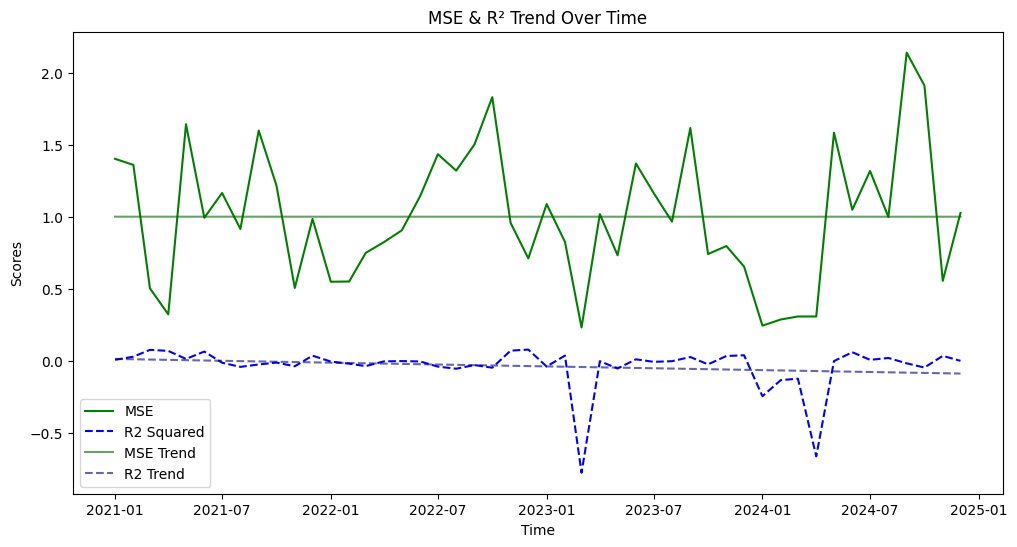

In [23]:
def show_performance_trend(scoring_df):
    scoring_df["date_ordinal"] = scoring_df["date"].apply(lambda x: x.toordinal())

    # Fit a linear trend line for MSE
    mse_trend = np.poly1d(np.polyfit(scoring_df["date_ordinal"], scoring_df["mse"], 1))
    
    # Fit a linear trend line for R²
    r2_trend = np.poly1d(np.polyfit(scoring_df["date_ordinal"], scoring_df["r2"], 1))
    
    # Generate trend values
    trend_dates = scoring_df["date_ordinal"]
    mse_trend_values = mse_trend(trend_dates)
    r2_trend_values = r2_trend(trend_dates)
    
    # Plot the actual values
    plt.figure(figsize=(12, 6))
    plt.plot(scoring_df.date, scoring_df.mse, label="MSE", color="green")
    plt.plot(scoring_df.date, scoring_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
    
    # Plot trend lines
    plt.plot(scoring_df.date, mse_trend_values, color="darkgreen", linestyle="solid", alpha=0.6, label="MSE Trend")
    plt.plot(scoring_df.date, r2_trend_values, color="navy", linestyle="dashed", alpha=0.6, label="R2 Trend")
    
    # Labels and legend
    plt.xlabel("Time")
    plt.ylabel("Scores")
    plt.legend()
    plt.title("MSE & R² Trend Over Time")
    plt.show()

show_performance_trend(scores_df)

#### Notes
- Extend training dates to 1 year
- Run same code

In [24]:
# Use 1 years worth of training data
updated_training_data = filter_data_on_date(
    data=weather_data,
    start=datetime.datetime(2020, 1, 1),
    end=datetime.datetime(2020, 12, 31)
)

updated_training_data.loc[:,[TARGET]] = updated_training_data[TARGET].shift(-1)
updated_training_data = updated_training_data.dropna()

_x_train, _y_train = updated_training_data[FEATURES], updated_training_data[TARGET]
_x_train = scaler.fit_transform(_x_train)
_dtrain = xgb.DMatrix(_x_train, label=_y_train)

yearly_model = xgb.train(params, _dtrain, num_boost_round=100)

In [25]:
to_test_dates = get_monthly_dates(2021, 1, 4)
scores_df = get_scoring(yearly_model, to_test_dates)

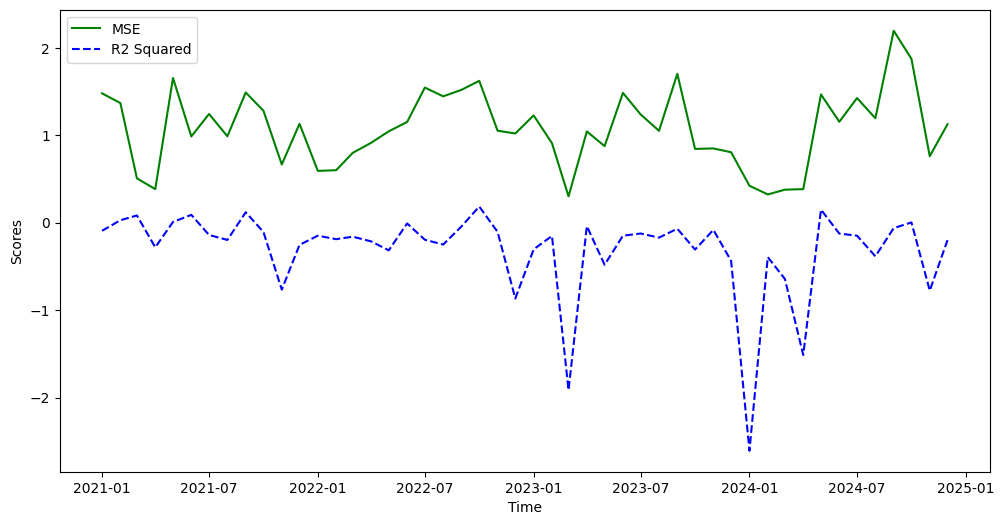

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(scores_df.date, scores_df.mse, label="MSE", color="green")
plt.plot(scores_df.date, scores_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Scores")
plt.legend()
plt.show()

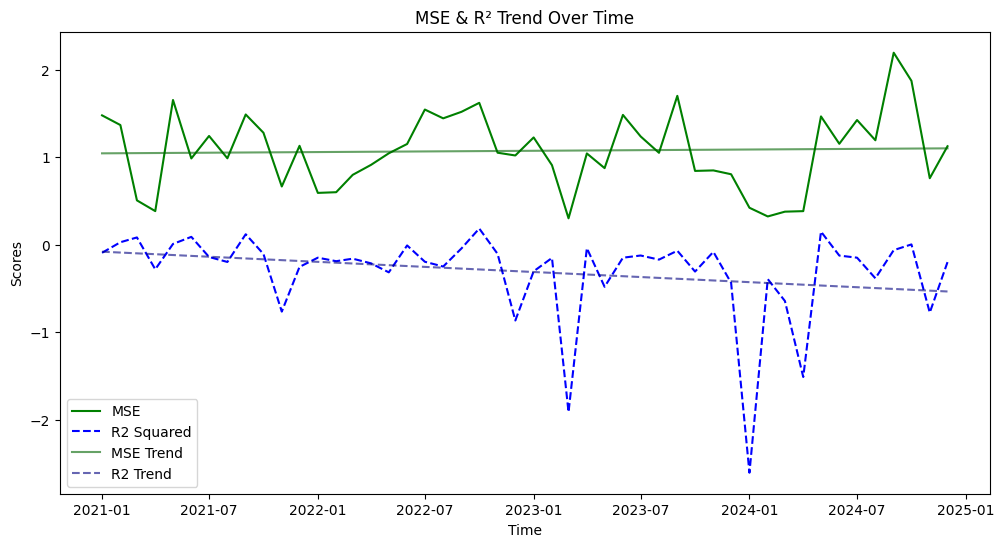

In [27]:
show_performance_trend(scores_df)